# MTMW14 Project 1: The ocean recharge oscillator model (ROM)

### Student No. 30825208

#### Github repository to find all code for this project: https://github.com/ao825208/MTMW14-Project-1.git

### Introduction:

The ocean recharge oscillator model (ROM) is a reduced coupled model for the El Nino Southern Oscillation (ENSO) built by Fei-Fei Jin (1997). ENSO is considered the most prominent mode of ocean-atmosphere variability, and it is important to understand the interaction between surface wind stress and thermocline depth along the equator. ROM can be described using two ordinary differential equations:

$$ \frac{dh_W}{dt} = -rh_W -\alpha bT_E -\alpha\xi _1 $$
$$ \frac{dT_E}{dt} = RT_E +\gamma h_W-e_n(h_W+bT_E)^3 +\gamma\xi _1 +\xi_2 $$

The prognostic variables are defined $h_W$ (west Pacific ocean thermocline depth) and $T_E$ (east Pacific SST anomaly). This project will focus on recreating Jin's ROM model in Python, explore how an appropriate time scheme method solves a forecast and ensemble for the coupled equation problem, and determine key numerical analysis properties such as stability and oscillatory behaviour. The time scheme I have chosen to focus on is the Runge-Kutta scheme, and I will use it to solve each problem in the tasks.

### Defining functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Thermocline depth equation (h)

def thermocline_depth(T, h, r, a, b, wind_stress):
   """Function that defines the equation for the west Pacific ocean thermocline depth (h)."""
   return -r*h - a*b*T - a*wind_stress

# SST anomaly equation (T)

def SST_anomaly(T, h, R, gamma, e, b, wind_stress, heating):
   """Function that defines the equation for the east Pacific Sea Surface Temperature anomaly (T)."""
   return R*T + gamma*h - e*(h + b*T)**3 + gamma*wind_stress + heating

### Runga-Kutta time scheme:

The fourth-order accurate Runga-Kutta time scheme can be defined as:

$$ q^{n+1} = q^n +\Delta t \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)$$

With each $k$ being defined:

$$ k_1 = f(q^n, n\Delta t), \\ k_2 = f \biggl[q^n + \frac{k_1 \Delta t}{2}, \biggl(n + \frac{1}{2} \biggr)\Delta t \biggr] $$
$$ k_3 = f \biggl [q^n + \frac{k_2 \Delta t}{2}, \biggl(n + \frac{1}{2} \biggr)\Delta t \biggr], \\ k_4 = f[q^n + k_3 \Delta t, (n+1)\Delta t] $$

Each of these parameters $k$ will approximate the function $f$ at the time step $\Delta t$. Each $k$ will be evaluated successfully where $f$ will be evaluated four times for a single time step. However, because $f$ is being constantly re-evaluated, the same $k$ parameter can not be used again, and so it is important to make sure a long time step is used for the scheme to be successful and hold a stable result.

In [3]:
def runge_kutta(T, h, nd_dt, nt, r, a, b, wind_stress, heating, gamma, R, e):
    """Function that solves the runge-kutta time step scheme for the coupled 
    ocean equations for thermocline depth and SST anomaly ordinary differential
    equation."""
    
    for i in range(0, nt):
        k1 = thermocline_depth(T[i], h[i], r, a, b, wind_stress)
        l1 = SST_anomaly(T[i], h[i], R, gamma, e, b, wind_stress, heating)
        
        k2 = thermocline_depth((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l2 = SST_anomaly((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k3 = thermocline_depth((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l3 = SST_anomaly((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k4 = thermocline_depth((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), r, a, b,\
                               wind_stress)
        l4 = SST_anomaly((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), R, gamma, e,\
                         b, wind_stress, heating)
        
        h[i+1] = h[i] + nd_dt*(1/6)*(k1 + 2*k2 + 2*k3 + k4)
        T[i+1] = T[i] + nd_dt*(1/6)*(l1 + 2*l2 + 2*l3 + l4)
    
    return h, T

### Task A: The neutral linear (deterministic) ROM

Using the above Runge-Kutta time scheme method, I will generate a ROM model excluding nonlinearity and external forcing (e.g. $\xi_1 , \xi_2 , e_n=0$). The coupling parameter will be set to its critical value, $\mu = \mu_c = \frac{2}{3}$, and the model will be run over a time period $\tau_c = 2\pi/\omega_c$ (approximately 41 months), which should produce a single stable oscillation. This model will be ran for $nt = 1000$ time steps.

In [4]:
# Recharge Oscillator Model (Tasks A, B, C)

def ROM(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0, mu = 2/3, \
        wind_stress = 0, heating = 0, t_min = 0, t_max = 41, nt = 1000):
    """Recharge oscillator model with initial parameters defined from theory 
    from Jin (1997a).
    
    Call signature:
        ROM(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,
            mu = 2/3, wind_stress = 0, heating = 0, t_min = 0, t_max = 41,
            nt = 1000)

    Parameters:
        b0 : float
            measure of thermocline slope
        gamma : float
            feedback of the thermocline gradient on the SST gradient
        c : int
            damping rate of SST anomalies
        r : float
            damping of the upper ocean heat content
        a : float
            enchanced easterly wind stress relation to the recharge of ocean
            heat content
        e : float
            nonlinearity of ROM
        mu : float
            coupling coefficient
        wind_stress : float
            random wind stress forcing
        heating : float
            random heating
        t_min : int
            minimum value of time
        t_max : int
            maximum value of time
        nt : int
            number of time steps"""
    
    # Arrays
    h = np.zeros(nt + 1)        # array to store values of thermocline depth
    T = np.zeros(nt + 1)        # array to store values of SST anomaly
    
    # Non-dimensionalised values
    T_nondim = 7.5
    h_nondim = 150
    t_nondim = 2

    # Time steps
    dt = ((t_max - t_min)/nt)   # time step
    nd_dt = dt/t_nondim         # non-dimensionalised dt

    # Initial conditions
    h[0] = 0/h_nondim
    T[0] = 1.125/T_nondim
    
    # Time axis setup
    t_axis = np.linspace(t_min, t_max, nt + 1)
    
    # Additional parameters
    b = b0*mu                   # measure of thermocline slope
    R = gamma*b - c             # Bjerknes positive feedback process
    
    # Defining runga-kutta for redimensionalisation
    rk = runge_kutta(T, h, nd_dt, nt, r, a, b, wind_stress, heating,\
                     gamma, R, e)

    # Redimensionalise thermocline depth (h) and SST anomaly (T)
    h_rk = rk[0]*h_nondim
    T_rk = rk[1]*T_nondim
    
    # Creating a figure
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 7))
    
    # Graph of SST anomaly and thermocline depth against time
    lns1 = ax1.plot(t_axis, h_rk, color = 'blue',\
                    label = 'Thermocline depth, hw (m)') 
    ax1.set_ylabel('hw (m)', fontsize = 15)
    ax1.set_xlabel('time (months)', fontsize = 15)
    ax2 = ax1.twinx()
    lns2 = ax2.plot(t_axis, T_rk, color = 'red', label = 'SST anomaly, Te (K)')
    ax2.set_ylabel('Te (K)', fontsize = 15)
    ax2.set_title('SST anomaly (Te) and Thermocline depth (hw) vs. time (t)',\
                  fontsize = 15)
    
    leg = lns1 + lns2
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, bbox_to_anchor = (1.4, 1))
    
    fig.tight_layout()

    # Graph of SST anomaly against thermocline depth
    ax3.plot(T_rk, h_rk)
    ax3.set_xlabel('Te (K)', fontsize = 15)
    ax3.set_ylabel('hw (m)', fontsize = 15)
    ax3.set_title('SST anomaly (Te) vs. Thermocline depth (hw)', fontsize = 15)
    fig.tight_layout()

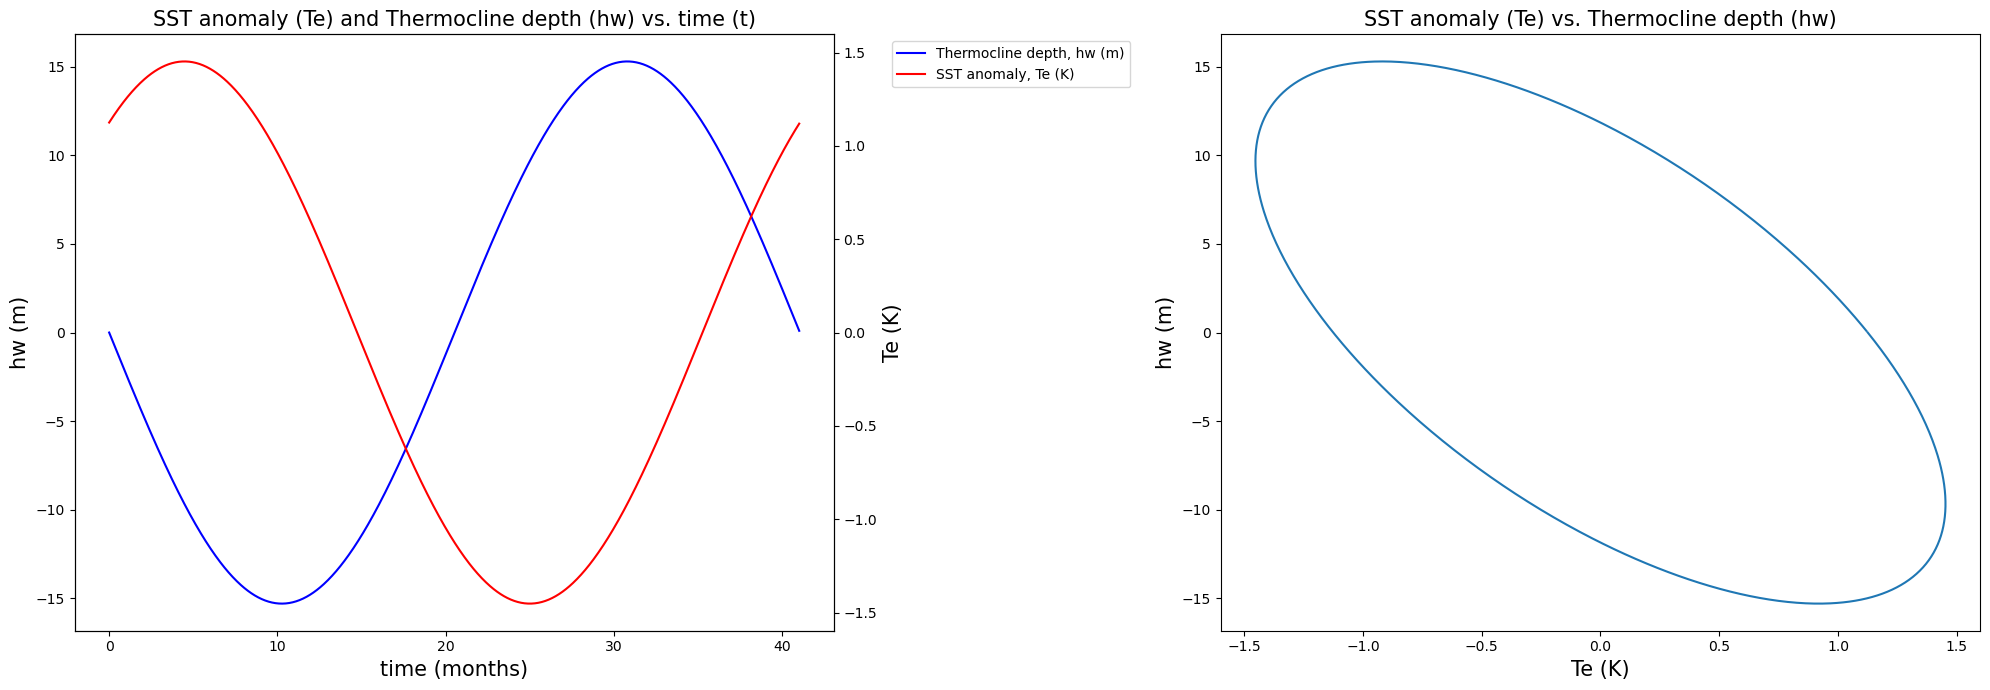

In [5]:
ROM()

##### Figure 1: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right) for exactly one periodic oscillation (41 months).

### Stability test:

Before proceeding, it is important that the time scheme method implemented is appropriate. To determine Runga-Kutta is an ideal scheme, a stability test must be taken. However, one cycle will not be enough to find out if this scheme is stable, we should take into account multiple periods such as for 5 complete periodic oscillations. By increasing the number of time steps, we should be able to prove that Runge-Kutta is stable.

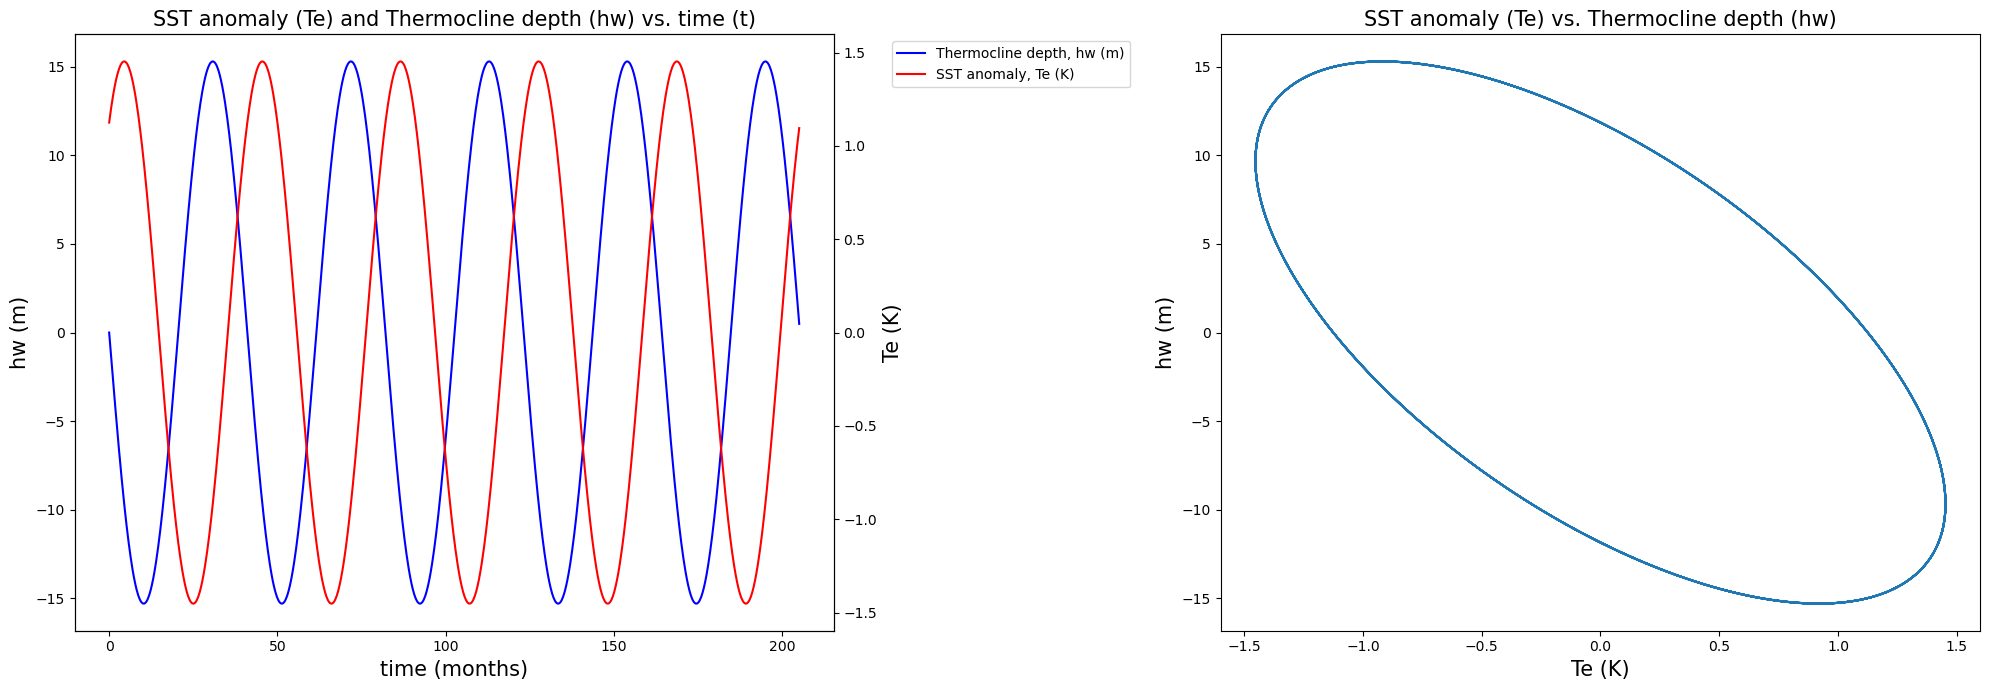

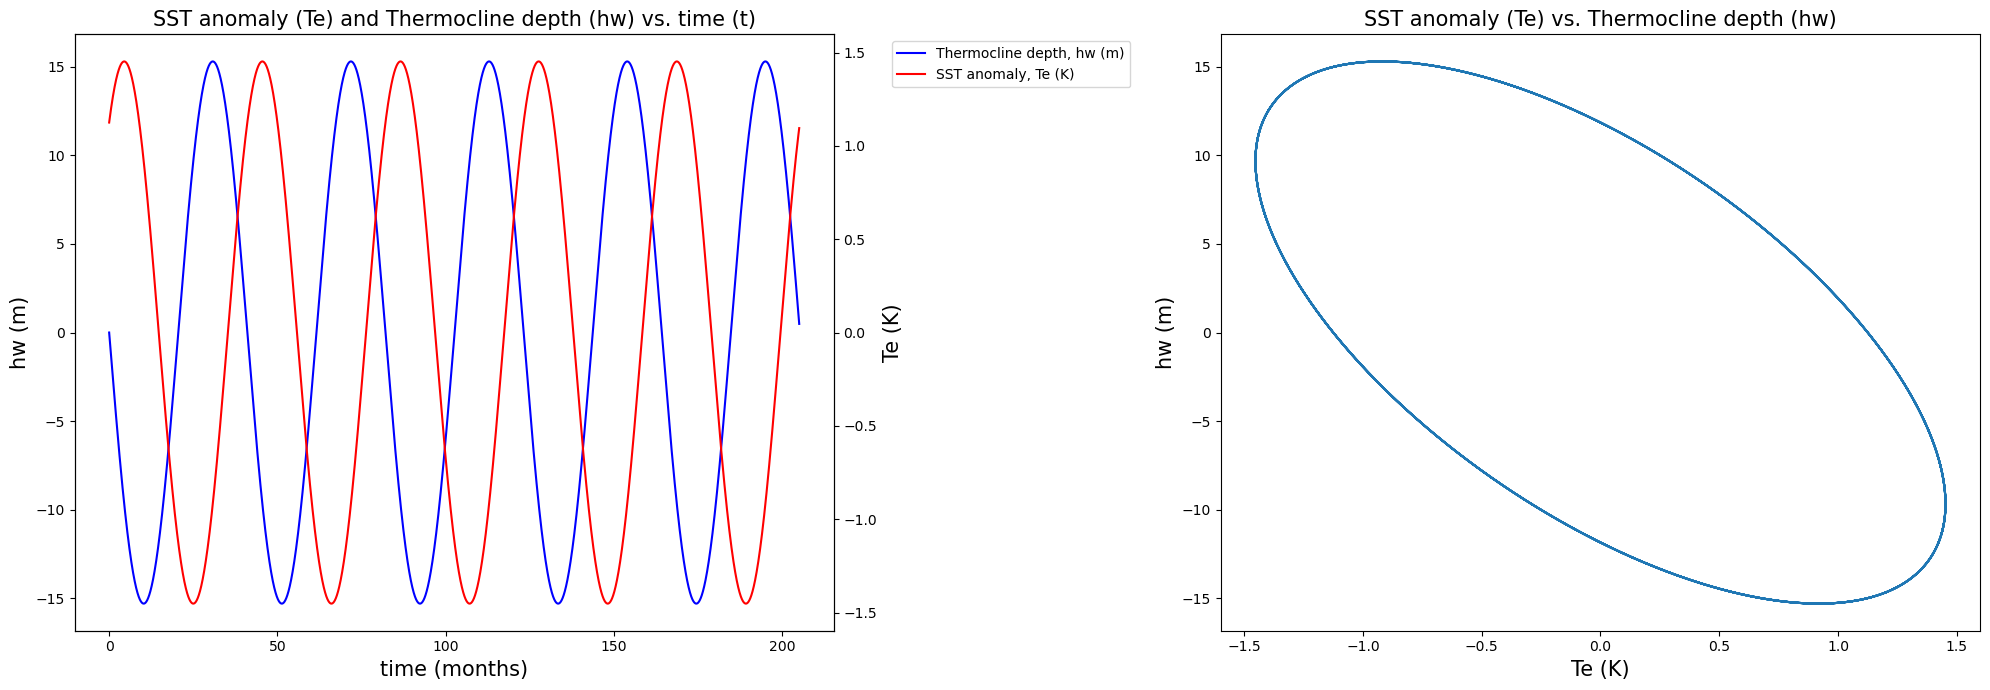

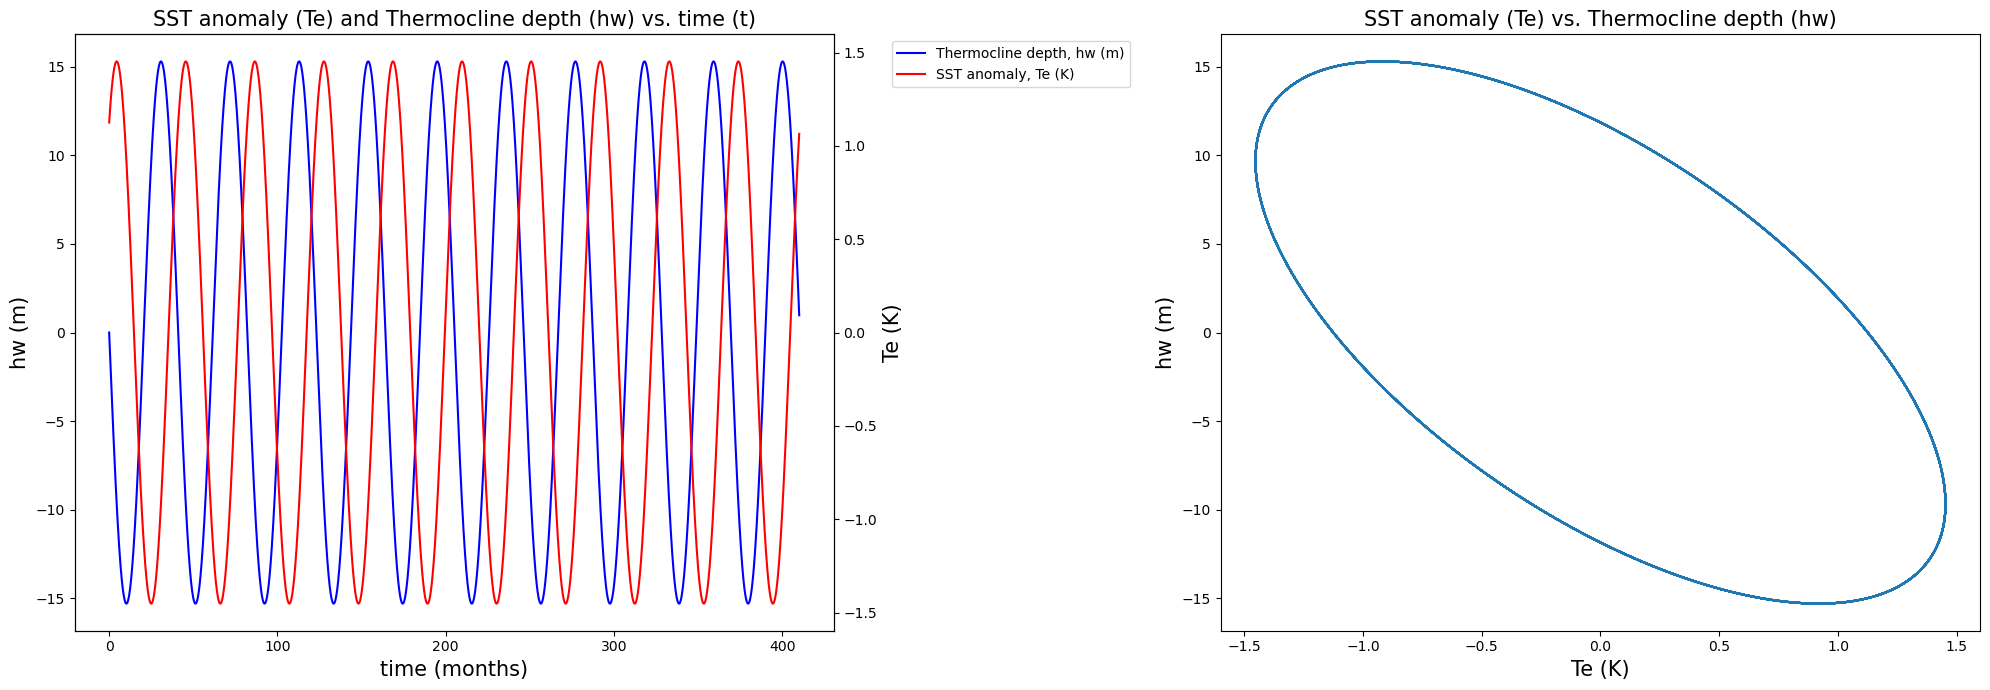

In [6]:
ROM(t_max = 41*5)
ROM(t_max = 41*5, nt = 10000)
ROM(t_max = 41*10, nt = 100000)

##### Figure 2: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot ($t$) (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), stability test for five and ten oscillations at increasing time steps, $nt$.

As shown above, no matter the number of time steps, the oscillations remain the same, and there is no damping or growth to the linear model. Therefore, we have successfully proven that the Runge-Kutta scheme is stable.

### Task B: Testing ROM behaviour around sub-critical and super-critical settings of the coupled parameter

For this task, I will demonstrate what would happen if we ran this model for five periodic oscillations, but with coupling parameter values set around their sub-critical ($\mu < \frac{2}{3}$) and their super-critical ($\mu > \frac{2}{3}$) values.

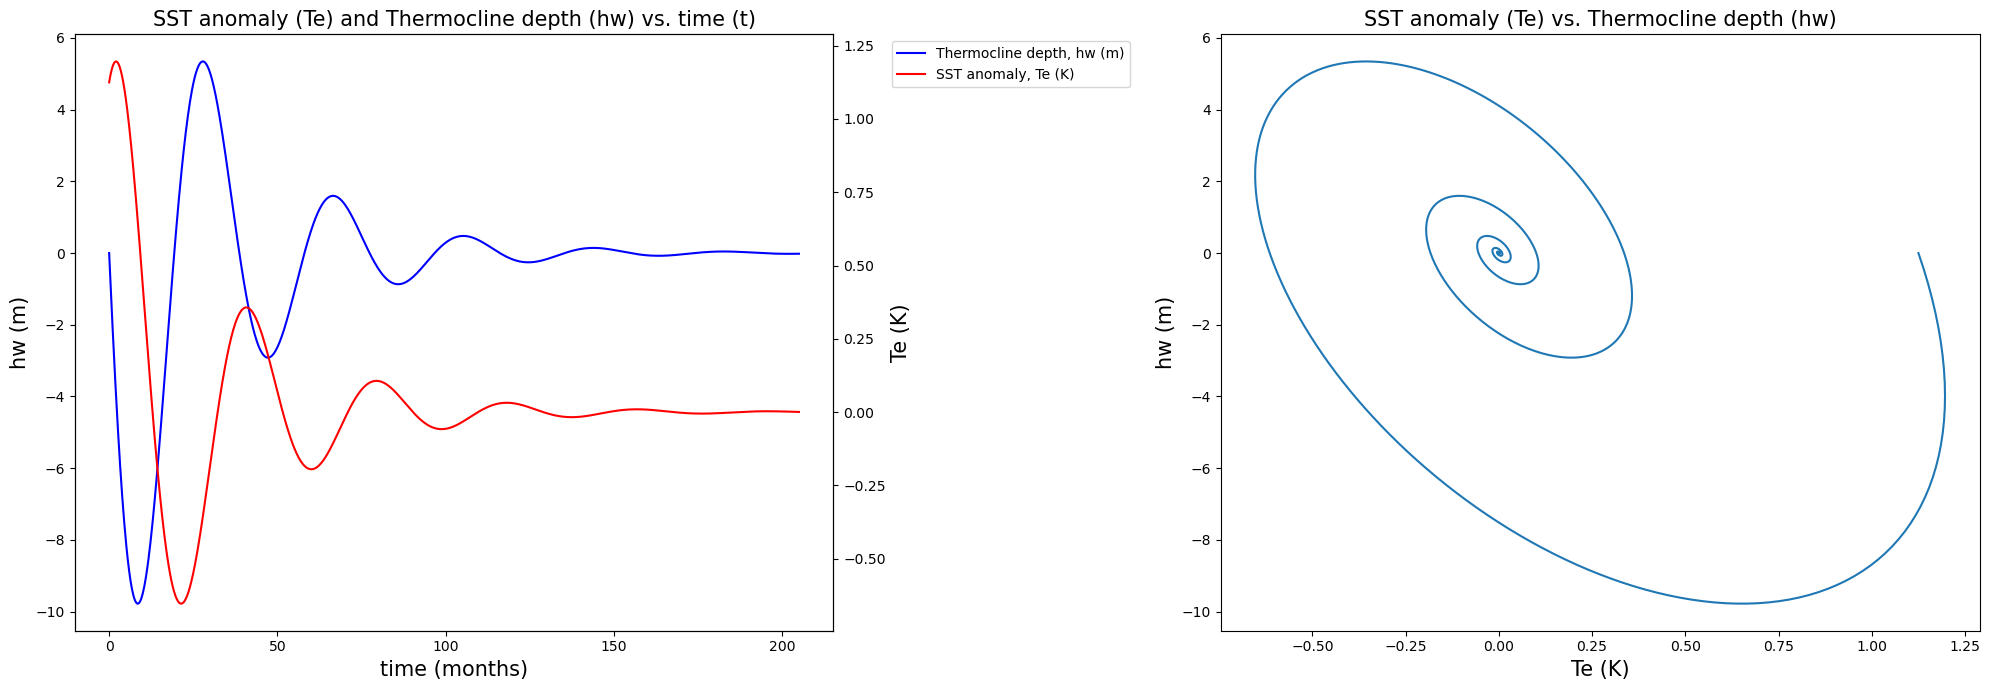

In [7]:
ROM(mu = 0.6, t_max = 41*5)     # sub-critical (mu < 2/3)

##### Figure 3: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), sub-critical model ($\mu = 0.6$).

In Figure 3, by setting the sub-critical value $\mu = 0.6$, the thermocline depth and SST anomaly appear to converge to $0$, generating a damping oscillation for both the time series and phase trajectory plot. When the system has two decaying modes, such as above, growth rate decreases rapidly and becomes negative. Using a sub-critical value for $\mu$ is clearly not ideal, as we obtain values that are almost negligible, which is not appropriate for modelling ENSO.

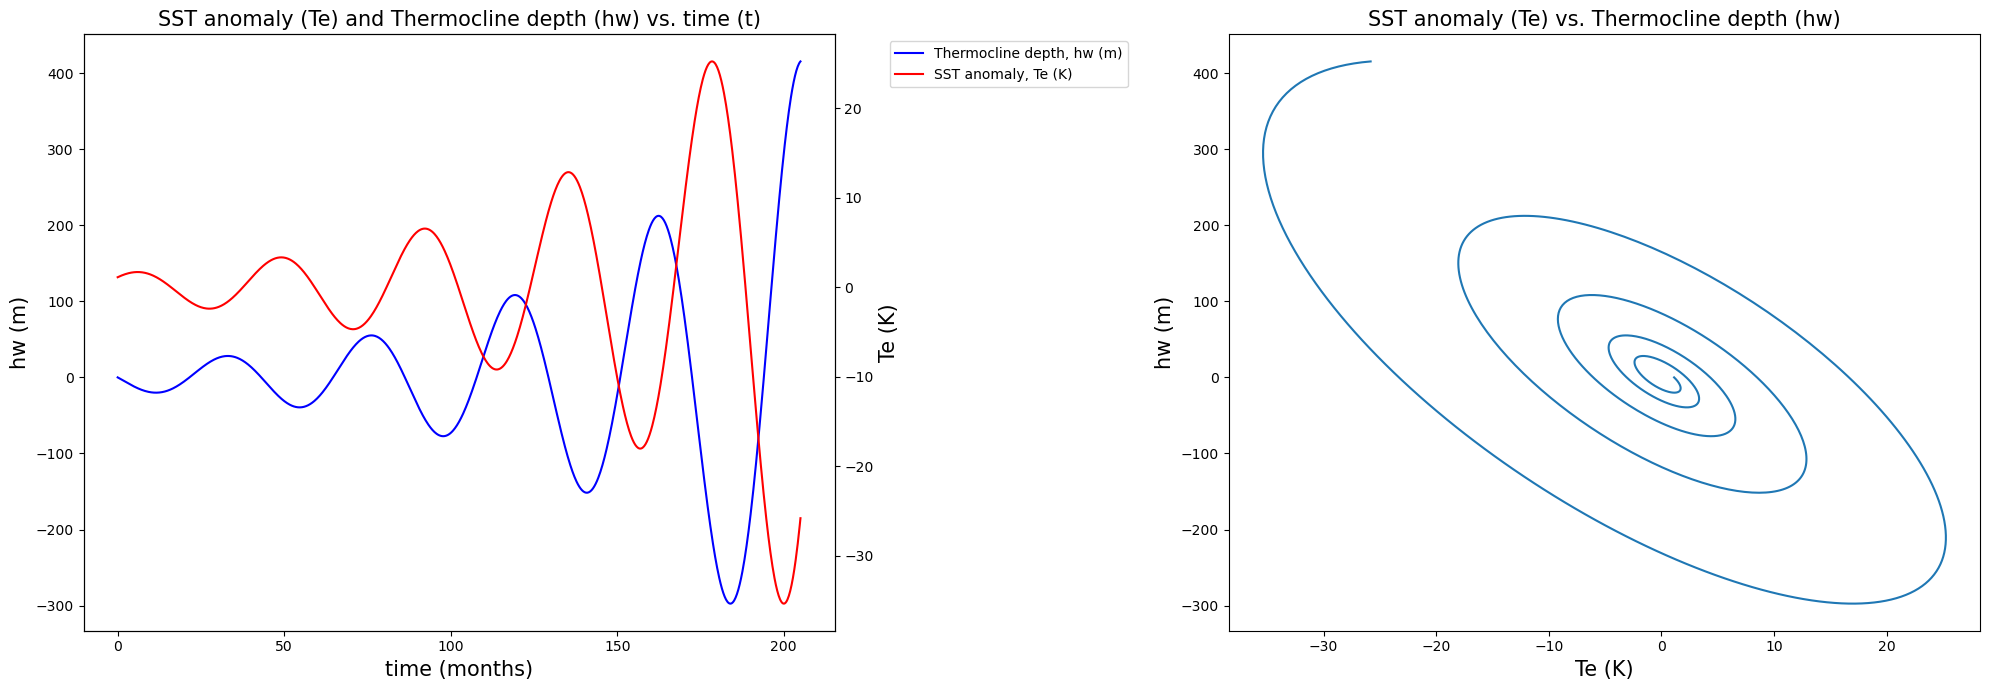

In [8]:
ROM(mu = 0.7, t_max = 41*5)     # super-critical (mu > 2/3)

##### Figure 4: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), super-critical model ($\mu = 0.7$).

In Figure 4, by setting the super-critical value $\mu = 0.7$, the thermocline depth and SST anomaly appear to grow to infinity, if more oscillations are considered, where variables are becoming increasingly large. With these models, linear growth rate is positive and the system gives an unstable oscillatory mode. This value for $\mu$ is not ideal for the model as it will generate some unrealistically huge values for modelling ENSO.

### Task C: Extending ROM to include the impact of non-linearity

To extend the current model, non-linearity should be considered. This can be turned on by setting the parameter $e_n = 0.1$. For this example, the coupling parameter will revert back to its critical and stable value $\mu = 2/3$ for appropriate values to model ENSO.

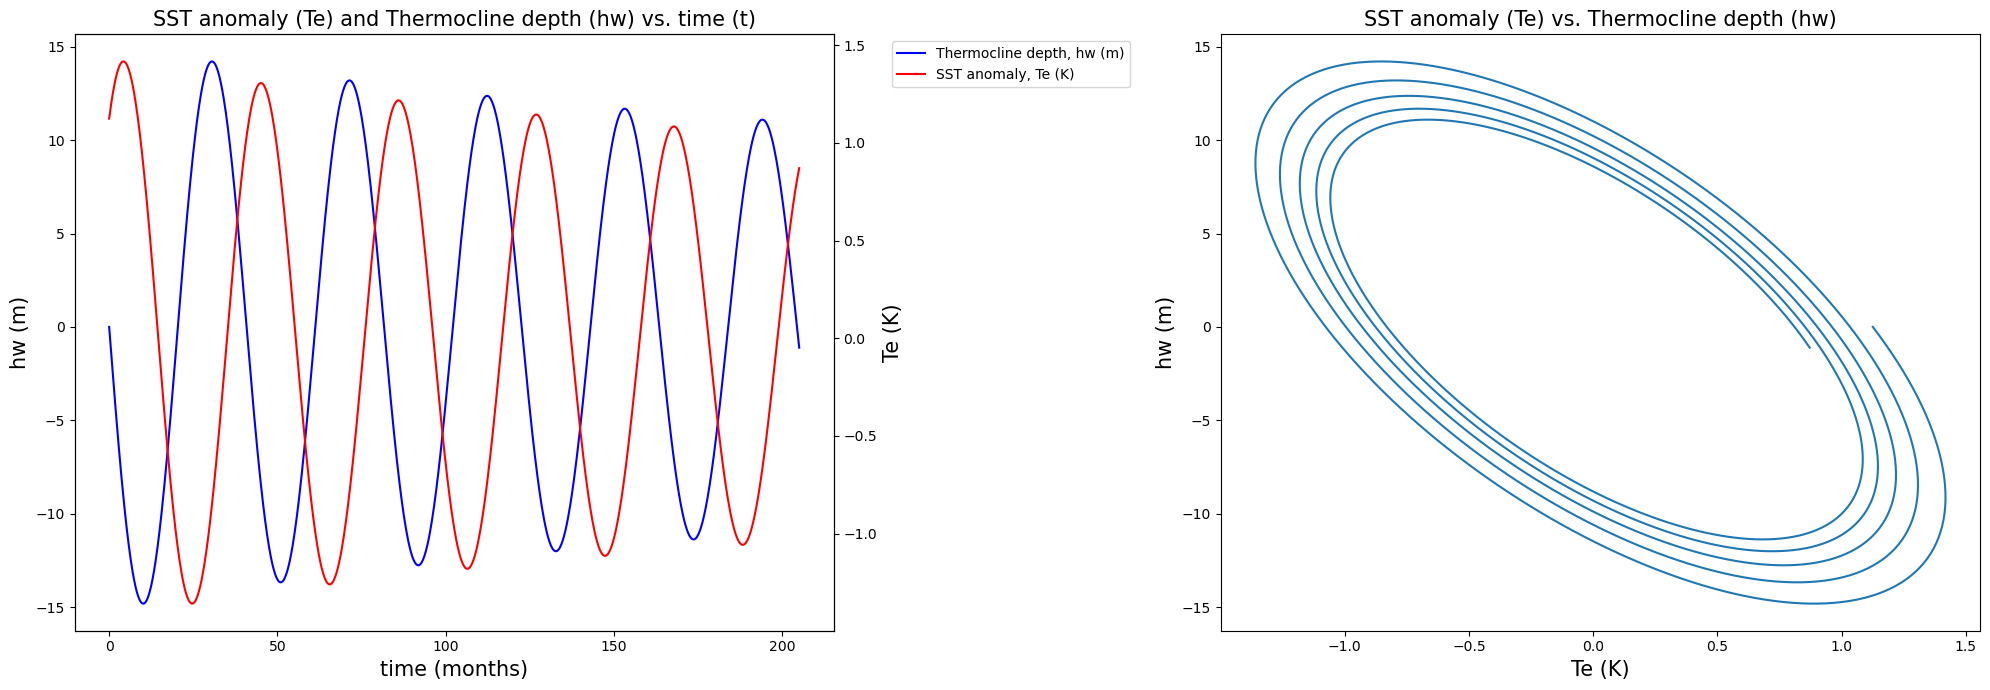

In [9]:
ROM(e = 0.1, t_max = 41*5)

##### Figure 5: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), with non-linearity variable ($e_n = 0.1$) turned on.

By turning on non-linearity, the system begins to dampen again for each periodic oscillation in Figure 5. However, compared to the sub-critical case, this rate of damping is not as fast. The solution is stable overall, but if we explore what would happen with more oscillations, the value will tend to $0$ as time increases. Compared to task A, this system is damping as variables decrease over time. Here we have used the same time step, but the system is still showing a negative growth rate.

What would happen if we were to increase $\mu$ beyond its critical value?

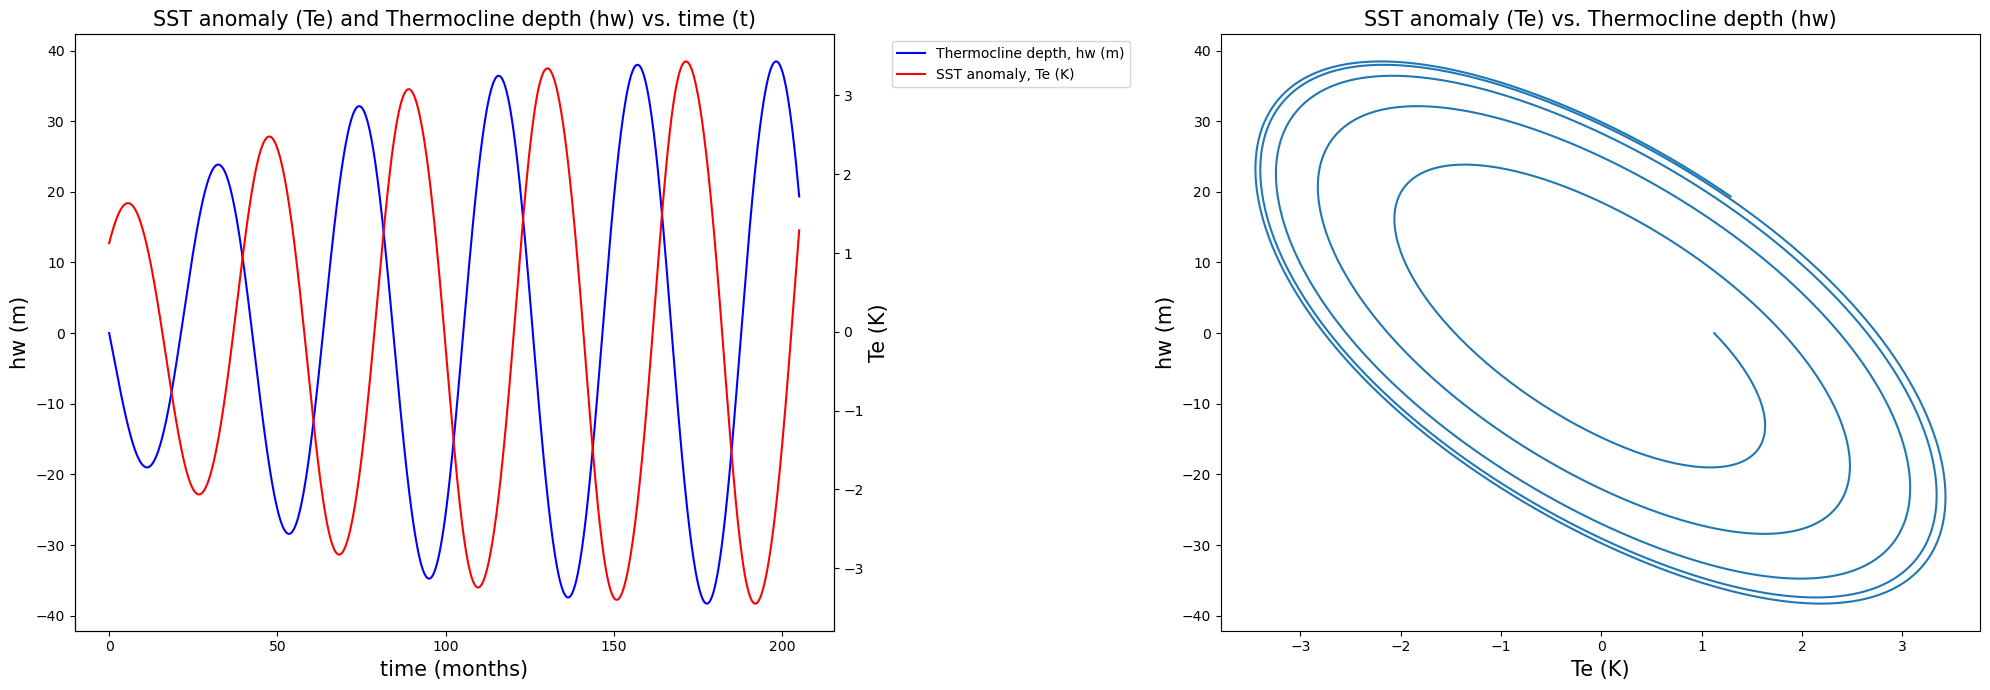

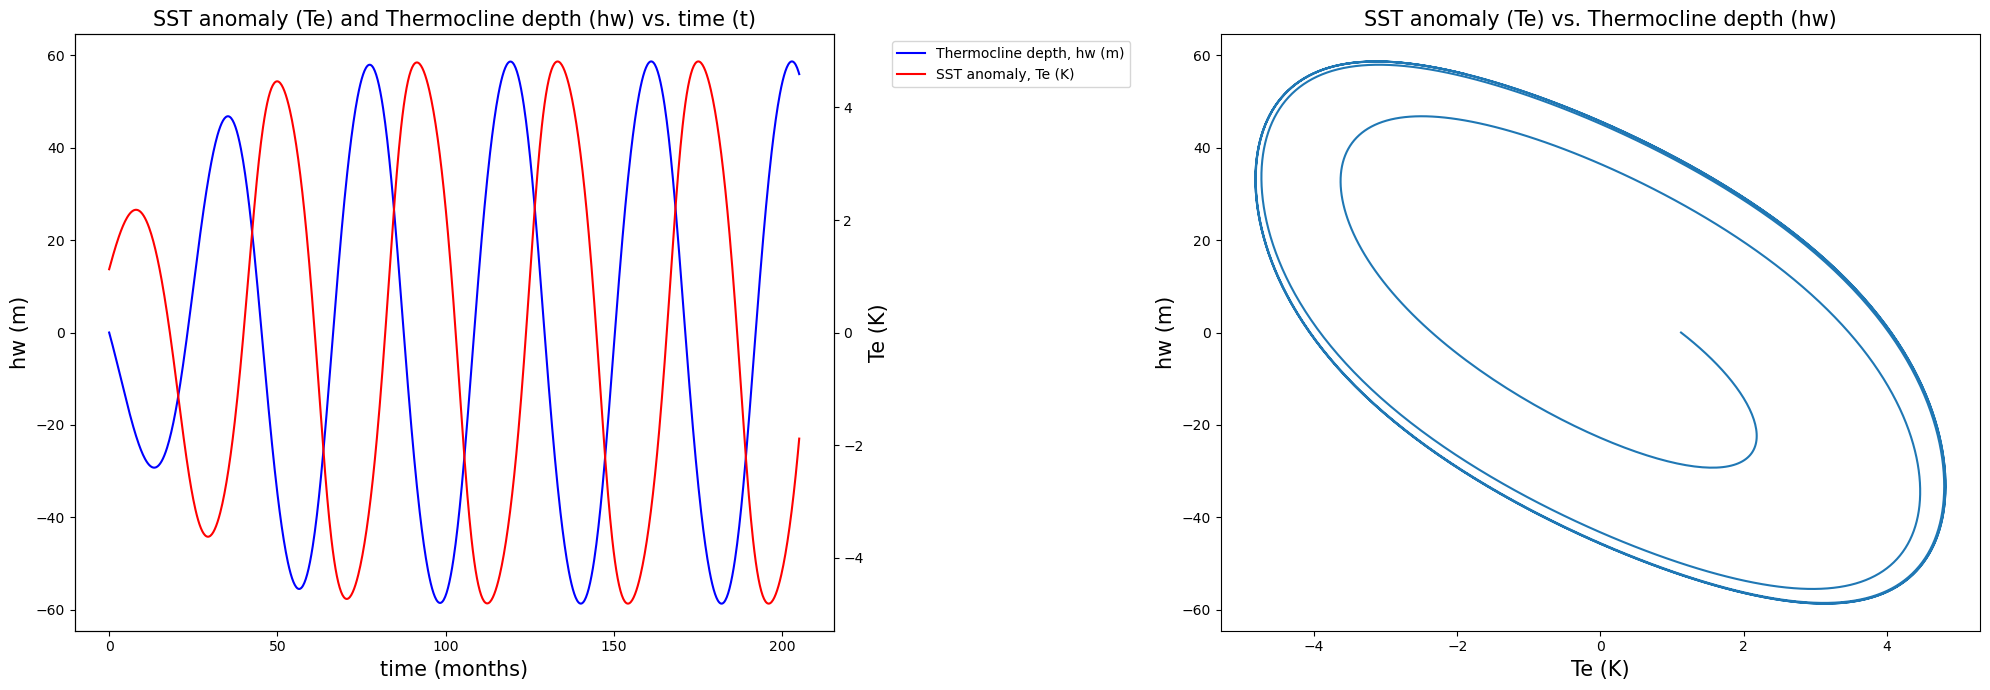

In [10]:
ROM(e = 0.1, mu = 0.7, t_max = 41*5)
ROM(e = 0.1, mu = 0.75, t_max = 41*5)

##### Figure 6: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), with non-linearity variable ($e_n = 0.1$) turned on and now considering super-critical values of $\mu$.

The time series on Figure 6 shows that instead of the variables damping, they appear to grow to their stable oscillations when we increase $\mu$ beyond its critical value with non-linearity switched on. The growth rate has been limited and the amplitude of the oscillations has returned to appropriate variable values.

### Task D: Test the self-excitation hypotheses

For this task, the coupling parameter $\mu$ will be modified to vary on an annual cycle, using the following equation:

$$\mu = \mu_0 \biggl(1+\mu_{ann} \cos \biggl(\frac{2\pi t}{\tau} - \frac{5\pi}{6} \biggr) \biggr)$$

To which the model will be modified to include non-linearity $e_n = 0.1$, and the new parameters will be set to determine an annual cycle, $\mu_0 = 0.75$, $\mu_{ann} = 0.2$ and $\tau = 12$ (months). To make sure units of time stay consistent, $\tau$ will be non-dimensionalised when the Runge-Kutta scheme solves for values of $\mu$ at each time step.

### Coupling parameter function (annual cycle variation):

In [11]:
def mu_D(mu0, mu_ann, t, tau_nondim):
    """Function that defines the coupling parameter that varies on an annual
    cycle."""
    return mu0*(1 + mu_ann*np.cos((2*np.pi*t/tau_nondim) - (5*np.pi/6)))

### Runge-Kutta scheme (including new coupling parameter function):

In [12]:
def runge_kutta_D(T, h, t, nd_dt, nt, r, a, c, wind_stress, heating, gamma,\
                  b0, e, mu0, mu_ann, tau_nondim):
    """Function that solves the runge-kutta time step scheme for the coupled 
    ocean equations for thermocline depth and SST anomaly ordinary differential
    equation. This model now considers the variation in the coupling parameter
    on an annual cycle."""
    
    for i in range(0, nt):
        mu = mu_D(mu0, mu_ann, t[i], tau_nondim)
        
        b = b0*mu                   # measure of thermocline slope
        R = gamma*b - c             # Bjerknes positive feedback process
        
        k1 = thermocline_depth(T[i], h[i], r, a, b, wind_stress)
        l1 = SST_anomaly(T[i], h[i], R, gamma, e, b, wind_stress, heating)
        
        k2 = thermocline_depth((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l2 = SST_anomaly((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k3 = thermocline_depth((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l3 = SST_anomaly((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k4 = thermocline_depth((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), r, a, b,\
                               wind_stress)
        l4 = SST_anomaly((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), R, gamma, e,\
                         b, wind_stress, heating)
        
        h[i+1] = h[i] + nd_dt*(1/6)*(k1 + 2*k2 + 2*k3 + k4)
        T[i+1] = T[i] + nd_dt*(1/6)*(l1 + 2*l2 + 2*l3 + l4)
        t[i+1] = t[i] + nd_dt
        
    return h, T, t

### Solving the new ROM:

In [13]:
# Recharge oscillator model (Task D)

def ROM_D(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0.1,\
          wind_stress = 0, heating = 0, t_min = 0, t_max = 41, nt = 1000,\
              mu0 = 0.75, mu_ann = 0.2, tau_nondim = 12/2):
    """Recharge oscillator model with initial parameters defined from theory 
    from Jin (1997a), now considering the variation of the coupling parameter,
    mu, on an annual cycle.
    
    Call signature:
        ROM_D(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,
            wind_stress = 0, heating = 0, t_min = 0, t_max = 41, nt = 1000,
            mu0 = 0.75, mu_ann = 0.2, tau_nondim = 12/6)

    New parameters:
        mu0 : float
            initial value for the coupling parameter
        mu_ann: float
            annual value for coupling parameter
        tau_nondim: int
            annual cycle (non-dimensionalised)"""
    
    # Arrays
    h = np.zeros(nt + 1)        # array to store values of thermocline depth
    T = np.zeros(nt + 1)        # array to store values of SST anomaly
    t = np.zeros(nt + 1)        # array to store values of time
    
    # Non-dimensionalised values
    T_nondim = 7.5
    h_nondim = 150
    t_nondim = 2

    # Time steps
    dt = ((t_max - t_min)/nt)   # time step
    nd_dt = dt/t_nondim         # non-dimensionalised dt

    # Initial conditions
    h[0] = 0/h_nondim
    T[0] = 1.125/T_nondim
    t[0] = 0/t_nondim
    t[1] = t[0] + nd_dt
    
    # Time axis setup
    t_axis = np.linspace(t_min, t_max, nt + 1)
    
    # Defining runga-kutta for redimensionalisation
    rk_D = runge_kutta_D(T, h, t, nd_dt, nt, r, a, c, wind_stress, heating,\
                         gamma, b0, e, mu0, mu_ann, tau_nondim)

    # Redimensionalise thermocline depth (h) and SST anomaly (T) and time (t)
    h_rk_D = rk_D[0]*h_nondim
    T_rk_D = rk_D[1]*T_nondim
    
    # Creating a figure
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 7))
    
    # Graph of SST anomaly and thermocline depth against time
    lns1 = ax1.plot(t_axis, h_rk_D, color = 'blue',\
                    label = 'Thermocline depth, hw (m)') 
    ax1.set_ylabel('hw (m)', fontsize = 15)
    ax1.set_xlabel('time (months)', fontsize = 15)
    ax2 = ax1.twinx()
    lns2 = ax2.plot(t_axis, T_rk_D, color = 'red', label = 'SST anomaly, Te (K)')
    ax2.set_ylabel('Te (K)', fontsize = 15)
    ax2.set_title('SST anomaly (Te) and Thermocline depth (hw) vs. time (t)',\
                  fontsize = 15)
    
    leg = lns1 + lns2
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, bbox_to_anchor = (1.4, 1))
    
    fig.tight_layout()

    # Graph of SST anomaly against thermocline depth
    ax3.plot(T_rk_D, h_rk_D)
    ax3.set_xlabel('Te (K)', fontsize = 15)
    ax3.set_ylabel('hw (m)', fontsize = 15)
    ax3.set_title('SST anomaly (Te) vs. Thermocline depth (hw)', fontsize = 15)
    fig.tight_layout()

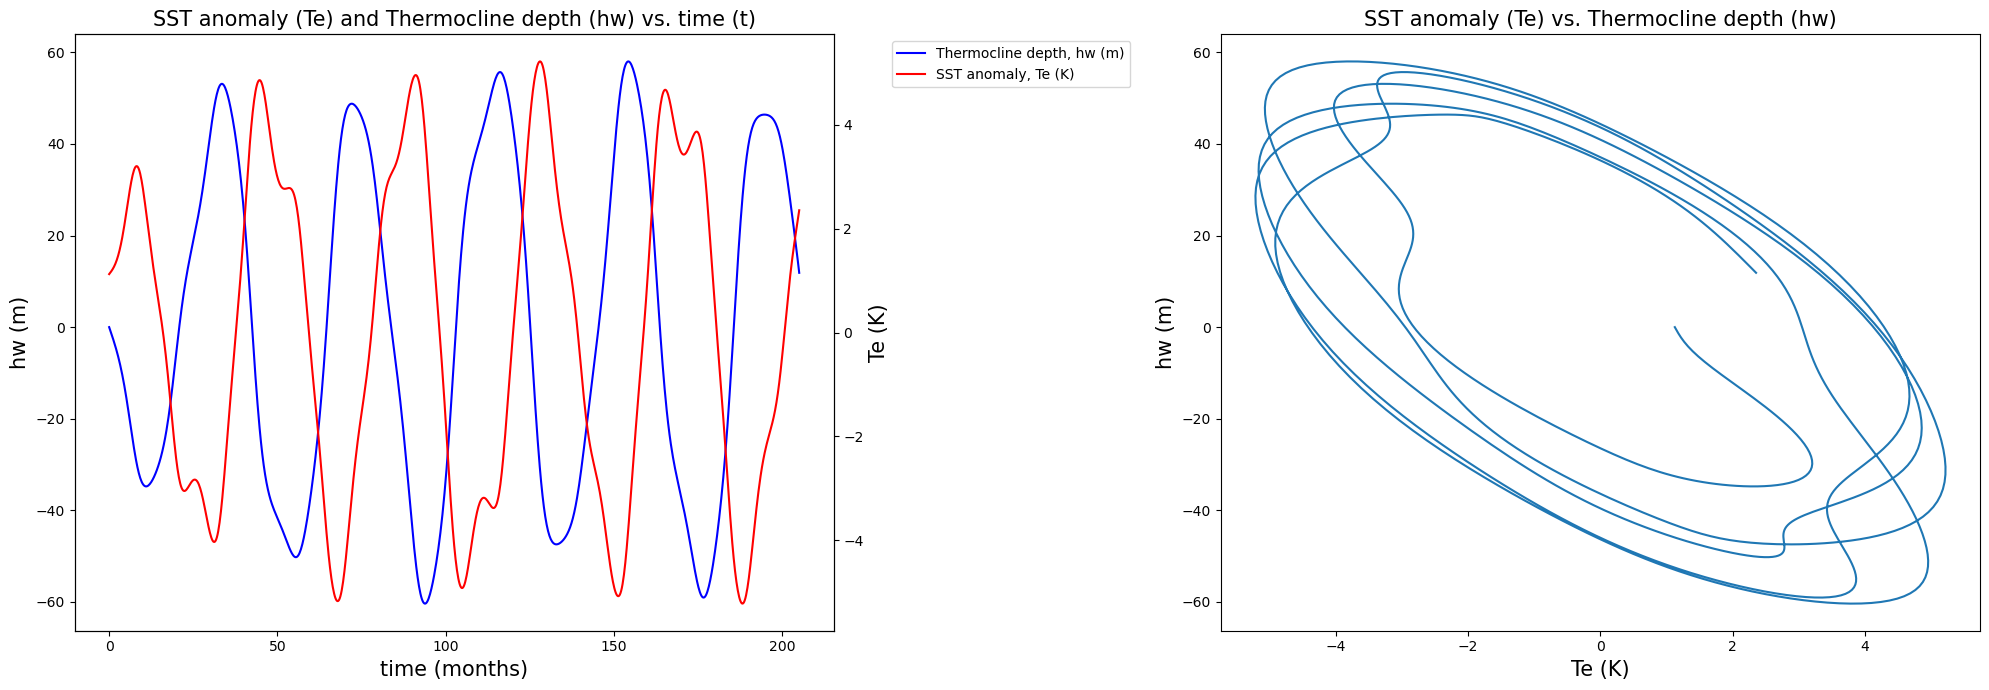

In [14]:
ROM_D(t_max = 41*5)

##### Figure 7: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), showing the variation in the coupling parameter considered with an annual cycle where $\tau = 12$.

Within five oscillations, the model experiences some stochastic noise coming from the new coupling parameter function added to the time-stepping scheme as demonstrated in Figure 7. The model tends to follow a stable oscillatory solution for its 41 months time period, and remains stable after the first couple of oscillations. When either variable $T_E$ or $h_W$ is increasing/decreasing, the noise is quite minimal, however when the model reaches a peak or a trough, there is some slight noise and variation in the values. This would actually make this model more accurate than the previous ones, since these variables would show some unpredictability as time increases, due to other various unknown parameters such as wind stress.

### Task E: Test the stochastic initiation hypotheses by adding noisy wind forcing to the linear model

Wind stress forcing can be added to the model using the following equation:

$$ \xi_1 = f_{ann}\cos \biggl(\frac{2\pi t}{\tau} \biggr) + f_{ran}W\frac{\tau_{cor}}{\Delta t} $$

$W$ is a random number picked within the range $-1$ and $1$, when we assume uniform probability for $W$. It represents the white noise process that the stochastic wind stress forcing experiences. When running this model, the following parameters will be set: $e_n = 0$ (linearity), $\mu_0 = 0.75$, $\mu_{ann} = 0.75$, $f_{ann} = 0.02$, $f_{ran} = 0.2$ and $\tau_{cor} = 1/30$ (one day). For simplicity, the time step $\Delta t$ will also be set to one day ($1/30$) as to make $\tau_{cor}$ consistent with $t$.

### Wind stress forcing equation:

In [15]:
def wind_stress_E(f_ann, t, tau_nondim, f_ran, W, tau_cor, nd_dt):
    """Function that defines the wind stress forcing for the recharge
    oscillator model."""
    return (f_ann*np.cos(2*np.pi*t/tau_nondim)) + f_ran*W*tau_cor/nd_dt

### ROM considering wind stress forcing:

In [16]:
def runge_kutta_E(T, h, t, nd_dt, nt, r, a, c, wind_stress, heating, gamma,\
                  b0, e, mu0, mu_ann, tau_nondim, f_ann, f_ran, tau_cor):
    """Function that solves the runge-kutta time step scheme for the coupled 
    ocean equations for thermocline depth and SST anomaly ordinary differential
    equation. This model now considers wind stress forcing."""
    
    for i in range(0, nt):
        mu = mu_D(mu0, mu_ann, t[i], tau_nondim)
        
        b = b0*mu                   # measure of thermocline slope
        R = gamma*b - c             # Bjerknes positive feedback process
        
        W = np.random.uniform(-1, 1, nt + 1)    # White noise
        
        wind_stress = wind_stress_E(f_ann, t[i], tau_nondim, f_ran, W[i],\
                                    tau_cor, nd_dt)
        
        k1 = thermocline_depth(T[i], h[i], r, a, b, wind_stress)
        l1 = SST_anomaly(T[i], h[i], R, gamma, e, b, wind_stress, heating)
        
        k2 = thermocline_depth((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l2 = SST_anomaly((T[i] + l1*(nd_dt/2)), (h[i] + k1*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k3 = thermocline_depth((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)),\
                               r, a, b, wind_stress)
        l3 = SST_anomaly((T[i] + l2*(nd_dt/2)), (h[i] + k2*(nd_dt/2)), R,\
                         gamma, e, b, wind_stress, heating)
        
        k4 = thermocline_depth((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), r, a, b,\
                               wind_stress)
        l4 = SST_anomaly((T[i] + l3*nd_dt), (h[i] + k3*nd_dt), R, gamma, e,\
                         b, wind_stress, heating)
        
        h[i+1] = h[i] + nd_dt*(1/6)*(k1 + 2*k2 + 2*k3 + k4)
        T[i+1] = T[i] + nd_dt*(1/6)*(l1 + 2*l2 + 2*l3 + l4)
        t[i+1] = t[i] + nd_dt
        
    return h, T, t

### Solving the new ROM:

In [17]:
def ROM_E(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,\
          wind_stress = 0, heating = 0, t_min = 0, t_max = 41/2,\
              mu0 = 0.75, mu_ann = 0.2, tau_nondim = 12/2, f_ann = 0.02,\
                  f_ran = 0.2, tau_cor = 1/60):
    """Recharge oscillator model with initial parameters defined from theory 
    from Jin (1997a), now considering the variation of the wind stress forcing
    over multiple time steps.
    
    Call signature:
        ROM_E(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,
            wind_stress = 0, heating = 0, t_min = 0, t_max = 41, mu0 = 0.75,
            mu_ann = 0.2, tau_nondim = 12/2, f_ann = 0.02, f_ran = 0.2,
            tau_cor = 1/60)

    New parameters:
        f_ann : float
            annual forcing
        f_ran: float
            random forcing
        tau_cor: float
            daily cycle (non-dimensionalised)"""
    
    # Non-dimensionalised values
    T_nondim = 7.5
    h_nondim = 150
    t_nondim = 2

    # Time steps
    dt = 1/30                   # time step
    nd_dt = dt/t_nondim         # non-dimensionalised dt
    
    nt = round((t_max - t_min)/nd_dt)
    
    # Arrays
    h = np.zeros(nt + 1)        # array to store values of thermocline depth
    T = np.zeros(nt + 1)        # array to store values of SST anomaly
    t = np.zeros(nt + 1)        # array to store values of time

    # Initial conditions
    h[0] = 0/h_nondim
    T[0] = 1.125/T_nondim
    t[0] = 0/t_nondim
    t[1] = t[0] + nd_dt
    
    # Time axis setup
    t_axis = np.linspace(t_min, t_max, nt + 1)
    
    # Defining runga-kutta for redimensionalisation
    rk_E = runge_kutta_E(T, h, t, nd_dt, nt, r, a, c, wind_stress, heating,\
                         gamma, b0, e, mu0, mu_ann, tau_nondim, f_ann, f_ran,\
                             tau_cor)

    # Redimensionalise thermocline depth (h) and SST anomaly (T) and time (t)
    h_rk_E = rk_E[0]*h_nondim
    T_rk_E = rk_E[1]*T_nondim
    
    # Creating a figure
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 7))
    
    # Graph of SST anomaly and thermocline depth against time
    lns1 = ax1.plot(t_axis*t_nondim, h_rk_E, color = 'blue',\
                    label = 'Thermocline depth, hw (m)') 
    ax1.set_ylabel('hw (m)', fontsize = 15)
    ax1.set_xlabel('time (months)', fontsize = 15)
    ax2 = ax1.twinx()
    lns2 = ax2.plot(t_axis*t_nondim, T_rk_E, color = 'red', label = 'SST anomaly, Te (K)')
    ax2.set_ylabel('Te (K)', fontsize = 15)
    ax2.set_title('SST anomaly (Te) and Thermocline depth (hw) vs. time (t)',\
                  fontsize = 15)
    
    leg = lns1 + lns2
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, bbox_to_anchor = (1.4, 1))
    
    fig.tight_layout()

    # Graph of SST anomaly against thermocline depth
    ax3.plot(T_rk_E, h_rk_E)
    ax3.set_xlabel('Te (K)', fontsize = 15)
    ax3.set_ylabel('hw (m)', fontsize = 15)
    ax3.set_title('SST anomaly (Te) vs. Thermocline depth (hw)', fontsize = 15)
    fig.tight_layout()

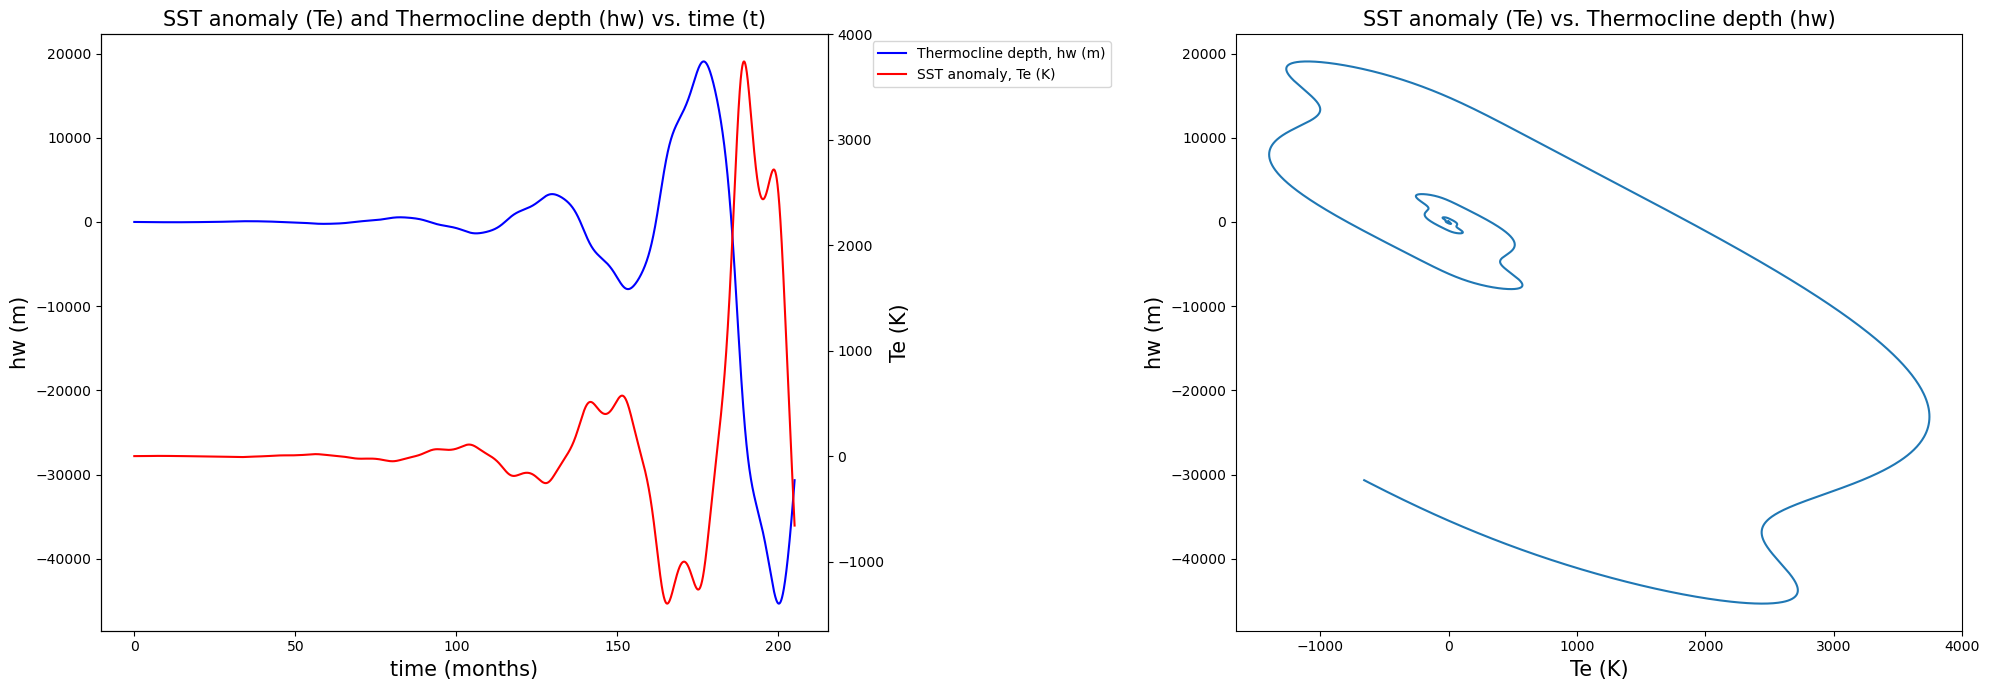

In [18]:
ROM_E(t_max = (41/2)*5)

##### Figure 8: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), adding noisy wind forcing ($\xi_1$) to the linear model ($e_n = 0$).

In Figure 8, the growth rate of the first few oscillations is very small and changes in the variables are very minimal. It is not until about the fourth periodic oscillation where extraordinary change begins to occur, and the growth rate of the amplitude of oscillations skyrockets to extreme values (as shown on the time series). The phase plot mimics this rapid growth by showing the solution to converge to infinity after its first few periodic oscillations. These values for $T_E$ and $h_W$ are very unrealistic for the model, and it would be ideal to consider the non-linear solution when applying stochastic wind forcing.

How does the wind forcing appear to affect the model?

#### Annual forcing ($f_{ann}$):

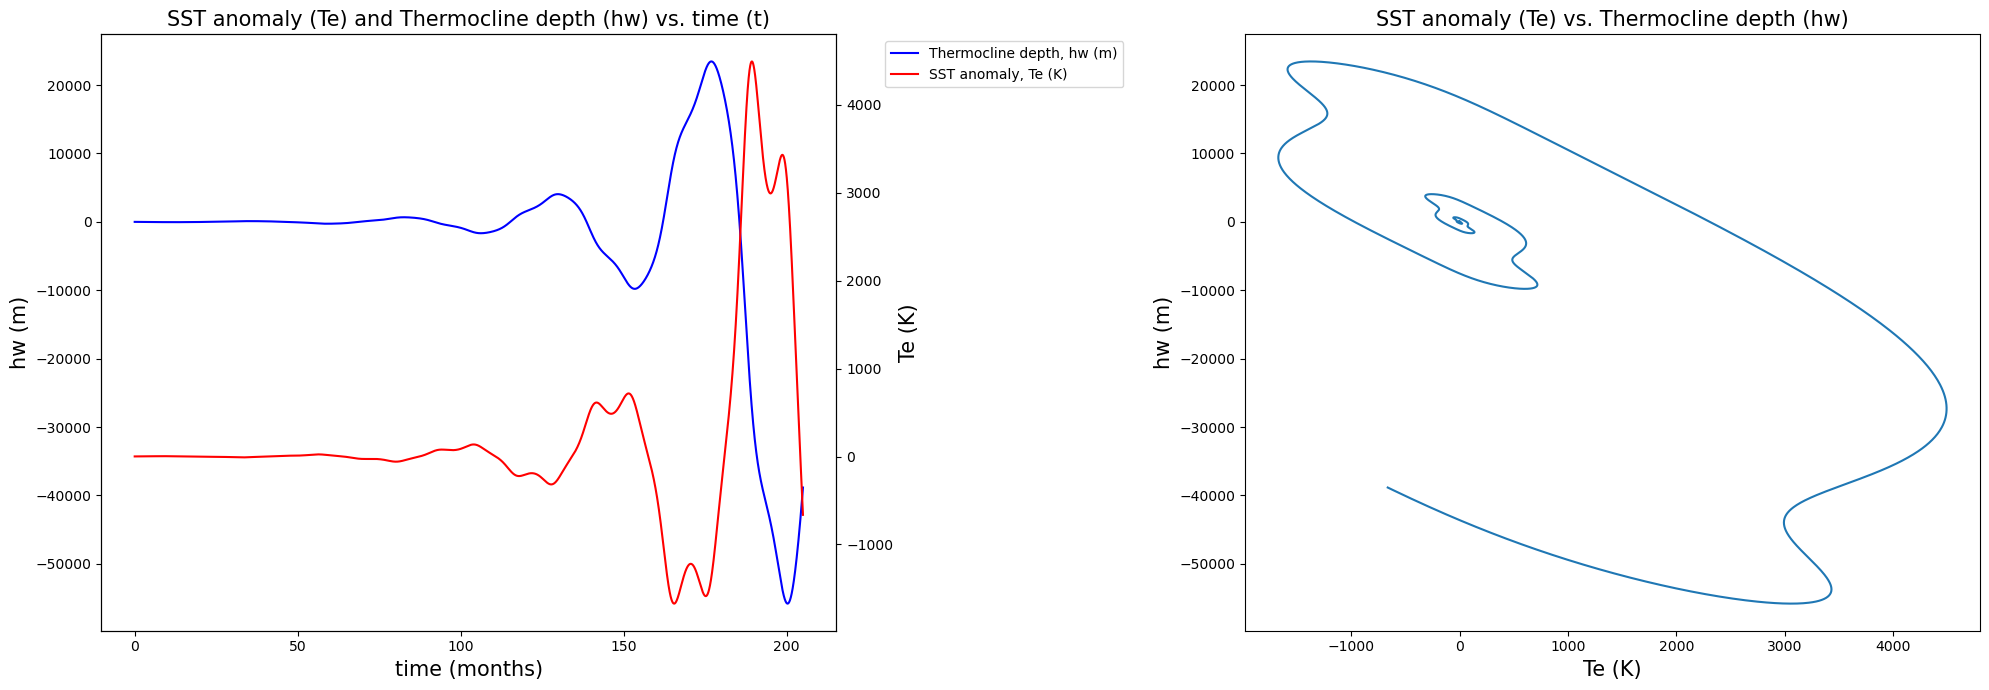

In [19]:
ROM_E(t_max = (41/2)*5, f_ran = 0) # Considering wind stress depending on f_ann

##### Figure 9: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), removing random wind forcing ($f_{ran} = 0$).

By setting $f_{ran} = 0$, this appears to escalate the values of $T_E$ and $h_W$ even further, as values of $-5\times10^4$m are being reached for example. Without $f_{ran}$, solutions tend to be extremely unstable and so annual forcing has a detrimental effect on the model with linearity.

#### Random forcing ($f_{ran}$):

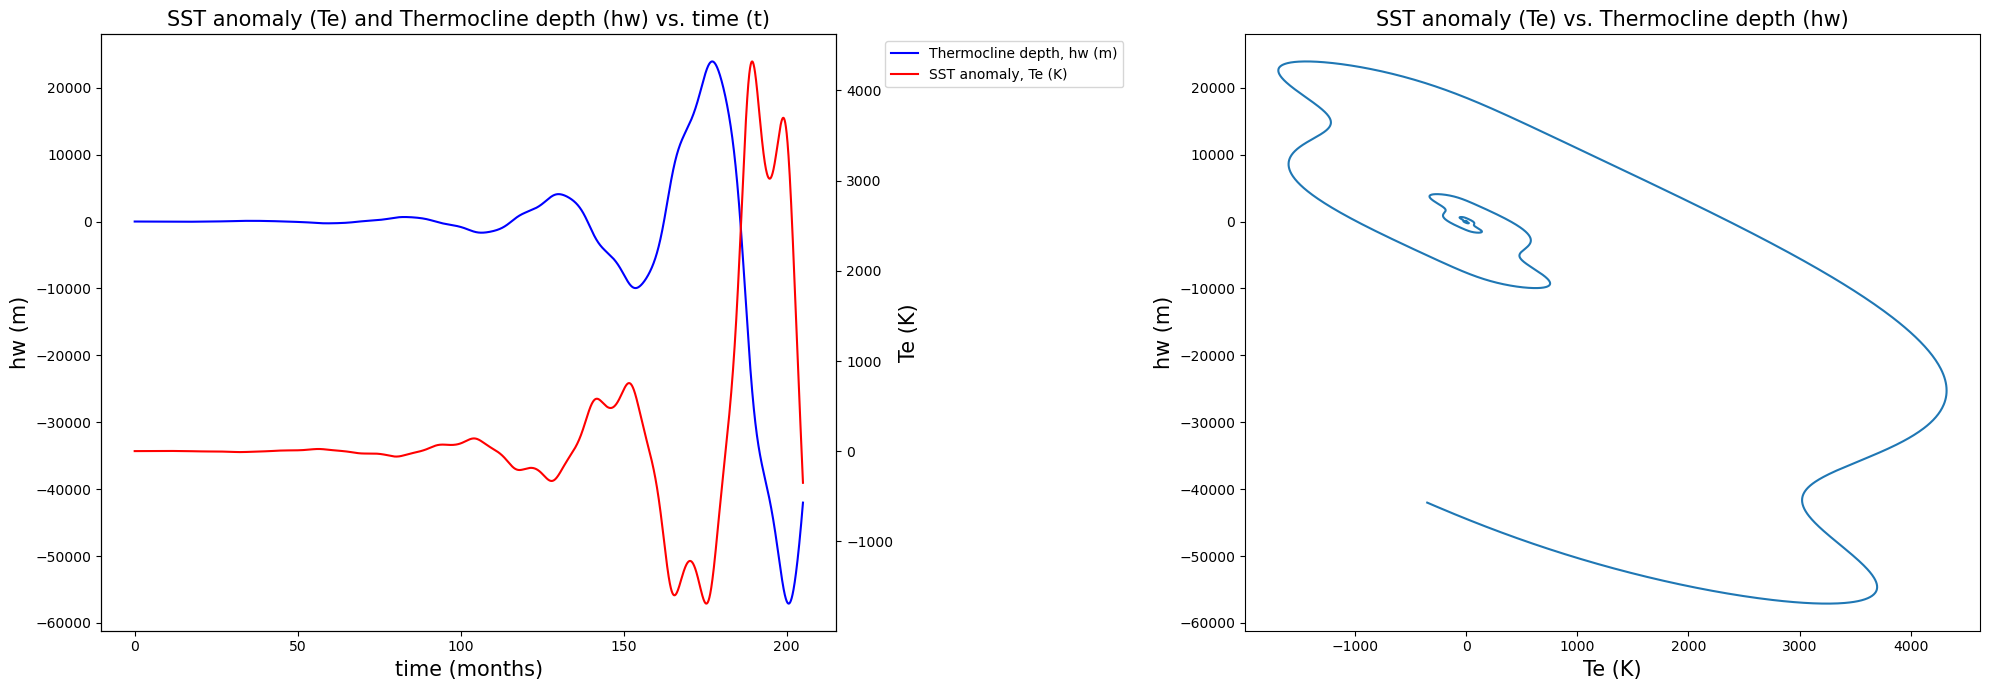

In [20]:
ROM_E(t_max = (41/2)*5, f_ann = 0) # Considering wind stress depending on f_ran

##### Figure 10: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), removing annual wind forcing ($f_{ann} = 0$).

The same issue arises with the annual forcing. Both the annual and random forcing depend on each other to provide more stable and appropriate values for the ROM variables. Therefore, a linear model is not appropriate for measuring ROM.

### Task F: Test the non-linearity and the stochastic forcing together

Now considering non-linearity ($e_n = 0.1$) with this new model, we arrive at the following system.

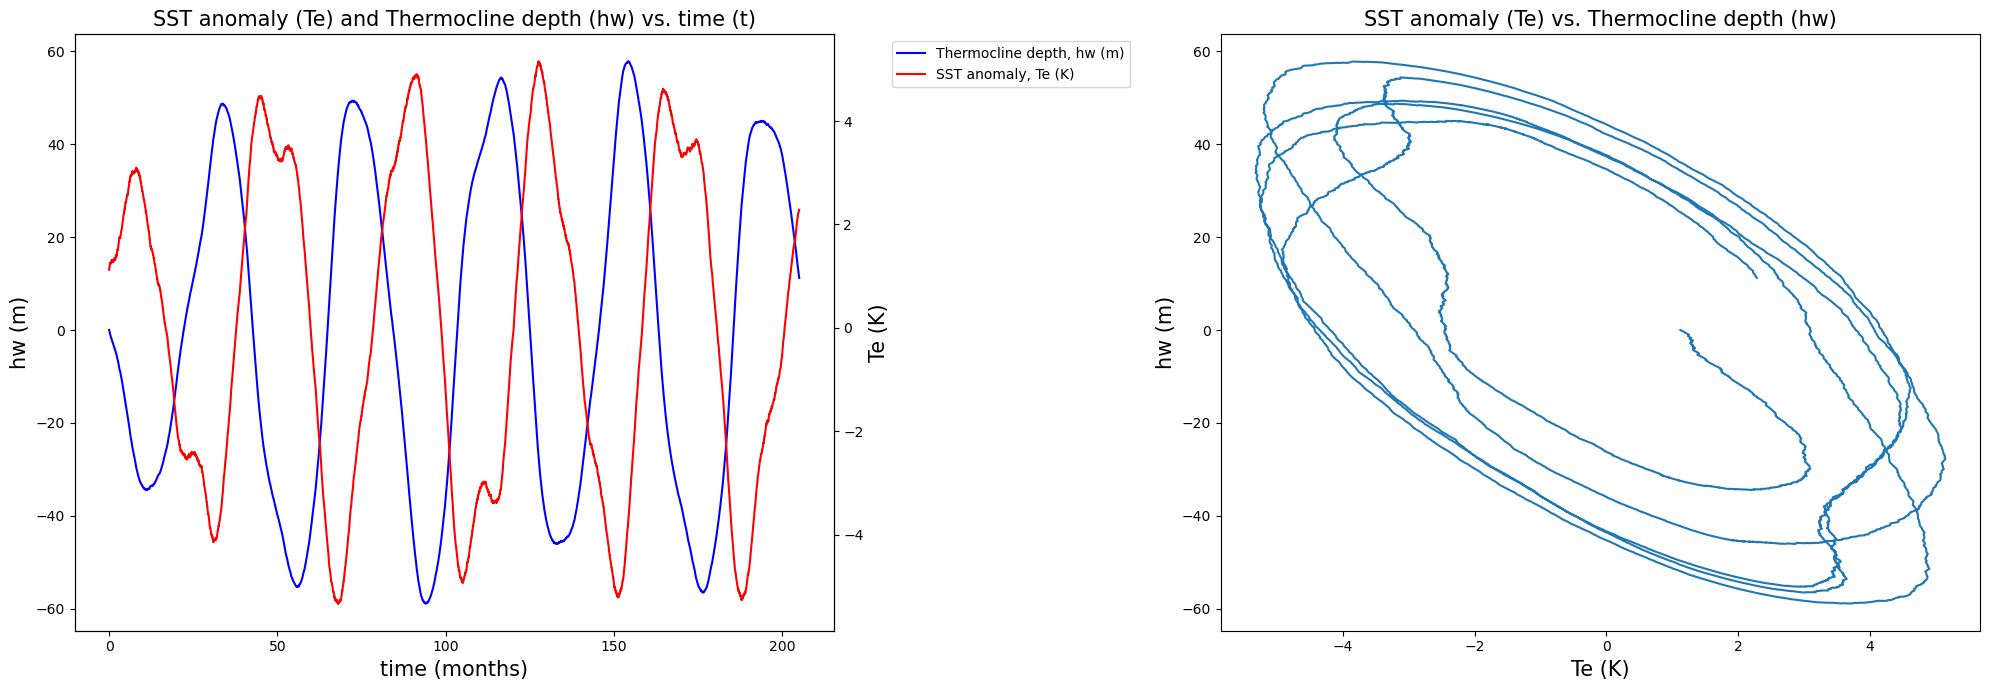

In [21]:
ROM_E(e = 0.1, t_max = (41/2)*5)

##### Figure 11: SST anomaly ($T_E$) and thermocline depth ($h_W$) time series plot (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), considering non-linearity for the wind stress forcing model.

The time series graph in Figure 11 shows slightly more noise than before and oscillations tend to increase or decrease for each period of 41 months. The trajectory of the phase plot experiences more noise as well for each time step, however the solution is now much more stable than in Task E, with more realistic solutions of variables for ENSO.

### Task G: Test whether chaotic behaviour can be triggered through addition of initial condition uncertainty

To design the ensemble, I will consider adding perturbations to the initial conditions that stay within the amplitude of the oscillations for Task E. This is to prevent the ensemble simulating chaotic motion at the initial conditions which it should not. Chaotic behaviour should only be simulated from valid uncertainty ranges. I will set perturbations in $T_E$ to be a random number within the range $-1 < T_{pert} < 1$, and $h_W$ to be within the range $-2.5 < h_{pert} < 2.5$. In terms of ensemble size, I will simulate $10$ different initial conditions and show how they vary in a time series, and demonstrate what the trajectories in the phase plot ($T_E$ vs. $h_W$) look like.

### Building and running the ensemble:

In [22]:
def ROM_G(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,\
          wind_stress = 0, heating = 0, t_min = 0, t_max = 41/2, nt = 10000,\
              mu0 = 0.75, mu_ann = 0.2, tau_nondim = 12/2, f_ann = 0.02,\
                  f_ran = 0.2, tau_cor = (1/60)):
    """Recharge oscillator model with initial parameters defined from theory 
    from Jin (1997a), now considering an ensemble of forecasts as an attempt 
    to simulate chaos.
    
    Call signature:
        ROM_G(b0 = 2.5, gamma = 0.75, c = 1, r = 0.25, a = 0.125, e = 0,
            wind_stress = 0, heating = 0, t_min = 0, t_max = 41, nt = 10000,
            mu0 = 0.75, mu_ann = 0.2, tau_nondim = 12/6, f_ann = 0.02,
            f_ran = 0.2, tau_cor = 1/30)"""
    
    # Non-dimensionalised values
    T_nondim = 7.5
    h_nondim = 150
    t_nondim = 2

    # Time steps
    dt = 1/30                   # time step
    nd_dt = dt/t_nondim         # non-dimensionalised dt
    
    nt = round((t_max - t_min)/nd_dt)
    
    # Arrays
    h = np.zeros(nt + 1)        # array to store values of thermocline depth
    T = np.zeros(nt + 1)        # array to store values of SST anomaly
    t = np.zeros(nt + 1)        # array to store values of time

    # Initial conditions
    h[0] = 0/h_nondim
    T[0] = 1.125/T_nondim
    t[0] = 0/t_nondim
    t[1] = t[0] + nd_dt
    
    # Time axis setup
    t_axis = np.linspace(t_min, t_max, nt + 1)
    
    # Implementing an ensemble model
    size = 10                   # ensemble size

    # Lists 
    T_ens = np.zeros([nt + 1, size])        # array to store ensemble of T
    h_ens = np.zeros([nt + 1, size])        # array to store ensemble of h
    
    # Loop to go through runga-kutta scheme for all perturbations of variables
    for ie in range(size):
        T_pert = np.random.uniform(-1, 1)       # perturbations of T
        h_pert = np.random.uniform(-2.5, 2.5)   # perturbations of h
        
        T_init = (1.125 + T_pert)/7.5
        T[0] = T_init
        
        h_init = (0 + h_pert)/150 
        h[0] = h_init
        
        rk_G = runge_kutta_E(T, h, t, nd_dt, nt, r, a, c, wind_stress,\
                             heating, gamma, b0, e, mu0, mu_ann, tau_nondim,\
                                 f_ann, f_ran, tau_cor)
        
        T_ens[:,ie] = rk_G[0]
        h_ens[:,ie] = rk_G[1]
        
    # Re-dimensionalise h and T
    New_T = T_ens*T_nondim
    New_h = h_ens*h_nondim
    
    # Creating a figure
    fig = plt.figure(figsize = (20, 7))
    
    # Setting figure rows and columns
    rows = 1
    columns = 2
    
    # Graph of SST anomaly (T) against time
    fig.add_subplot(rows, columns, 1)
    plt.plot(t_axis*t_nondim, New_T)
    plt.ylabel('Temperature (K)', fontsize = 15)
    plt.xlabel('time (months)', fontsize = 15)
    plt.title('SST anomaly (Te) vs. time (t)', fontsize = 15)
    plt.tight_layout()
    
    # Graph of SST anomaly (T) against thermocline depth (h)
    fig.add_subplot(rows, columns, 2)
    plt.plot(New_T, New_h)
    plt.xlabel('Te (K)', fontsize = 15)
    plt.ylabel('hw (m)', fontsize = 15)
    plt.title('SST anomaly (Te) vs. Thermocline depth (hw)', fontsize = 15)
    plt.tight_layout()

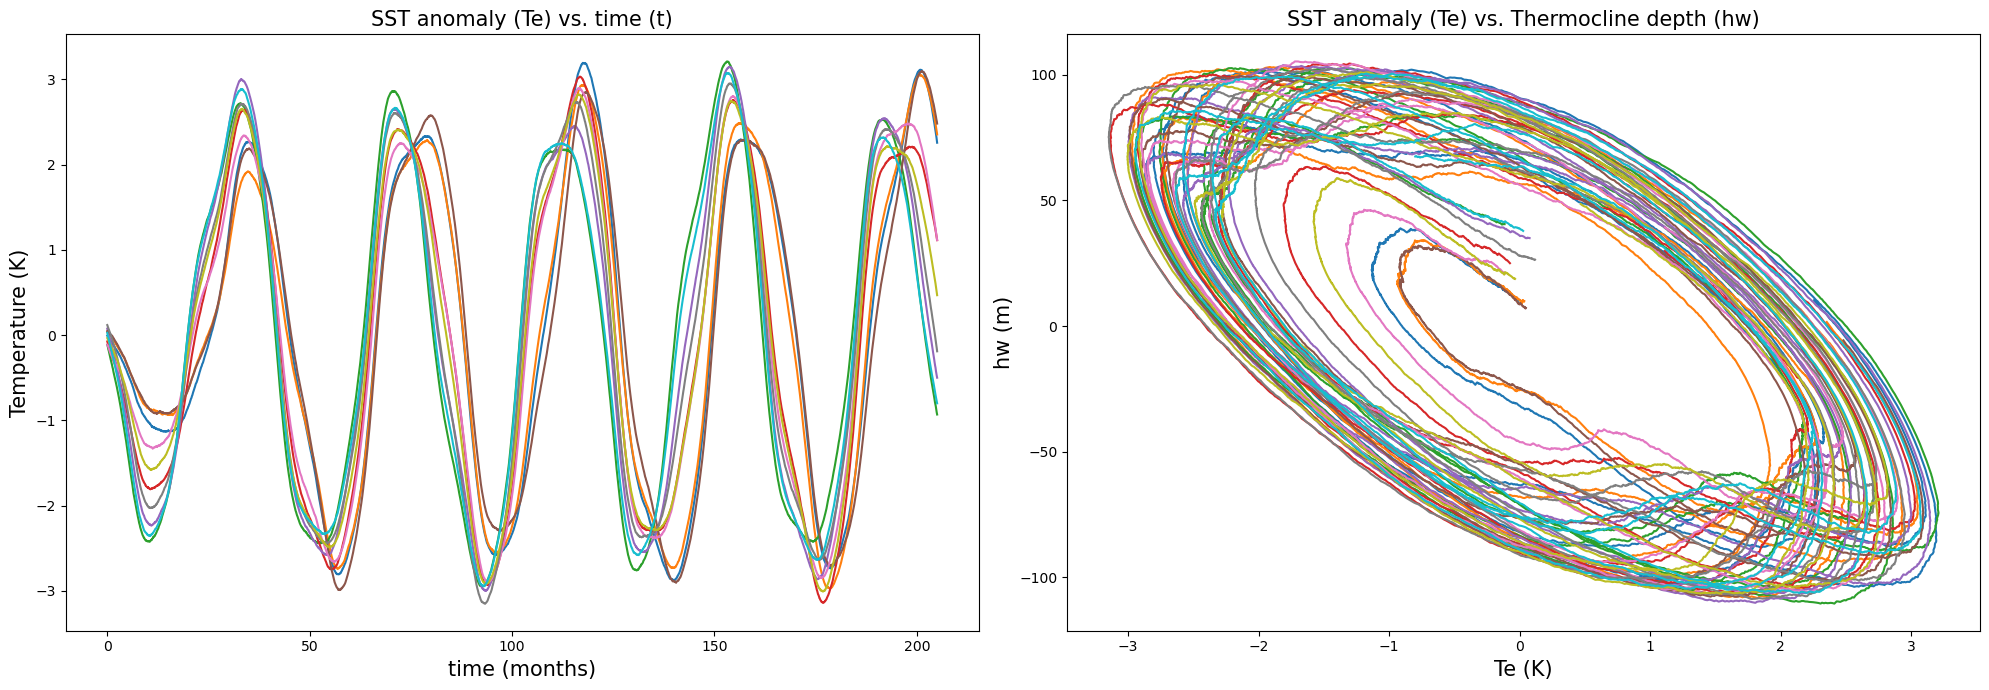

In [23]:
ROM_G(e = 0.1, t_max = (41/2)*5)

##### Figure 12: SST anomaly ($T_E$) plume time series graph (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), with an ensemble size of 10.

Figure 12 shows a plume diagram for SST anomalies on the left, and how the different initial conditions for $T_E$ vary over time. At the beginning of the oscillations, there is slight disorder since the initial conditions are differing between a moderately large range. However, as more periodic oscillations are considered, the different ensemble members correlate quite closely together and do not simulate chaos. This ensemble resembles the observed ENSO signals found in Jin's paper, as it follows a steady stable trend for multiple periodic oscillations.

If we were to increase stochastic forcing, can we simulate chaos?

### Increasing stochastic forcing:

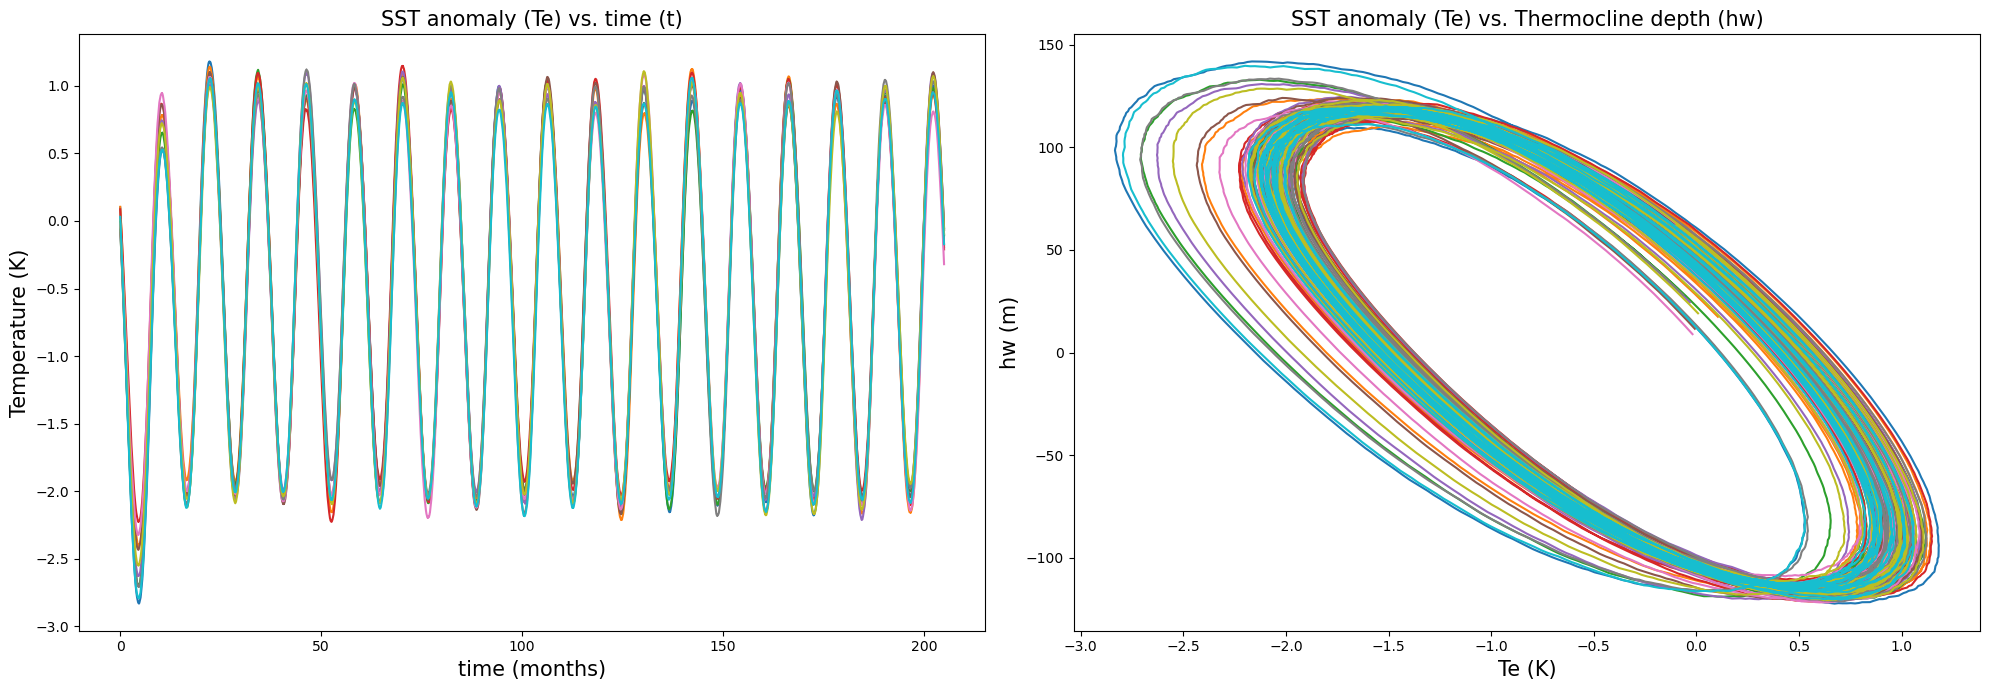

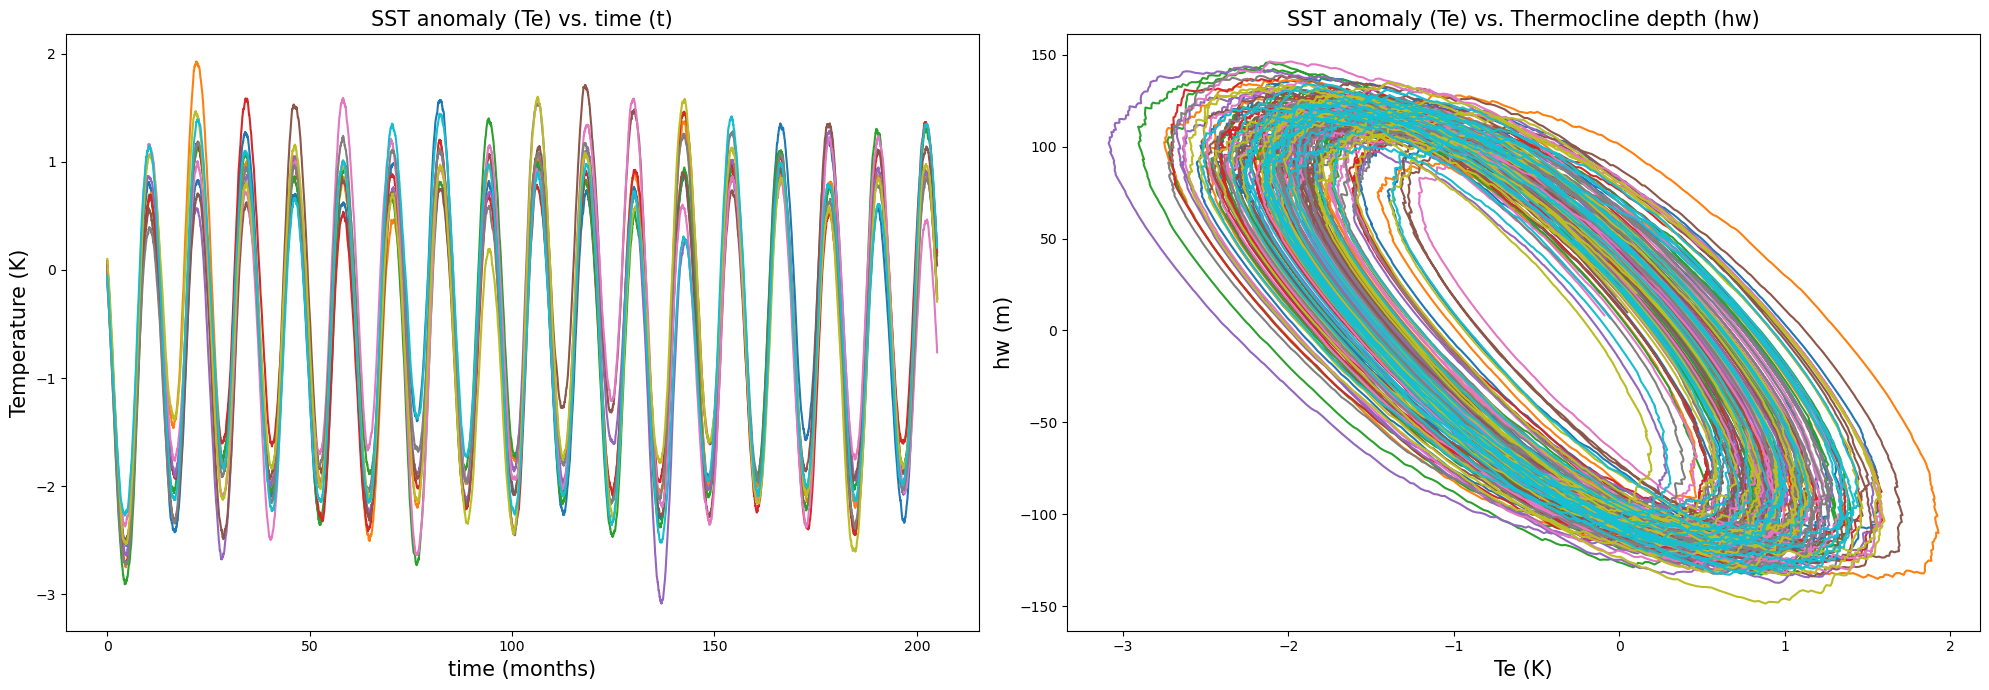

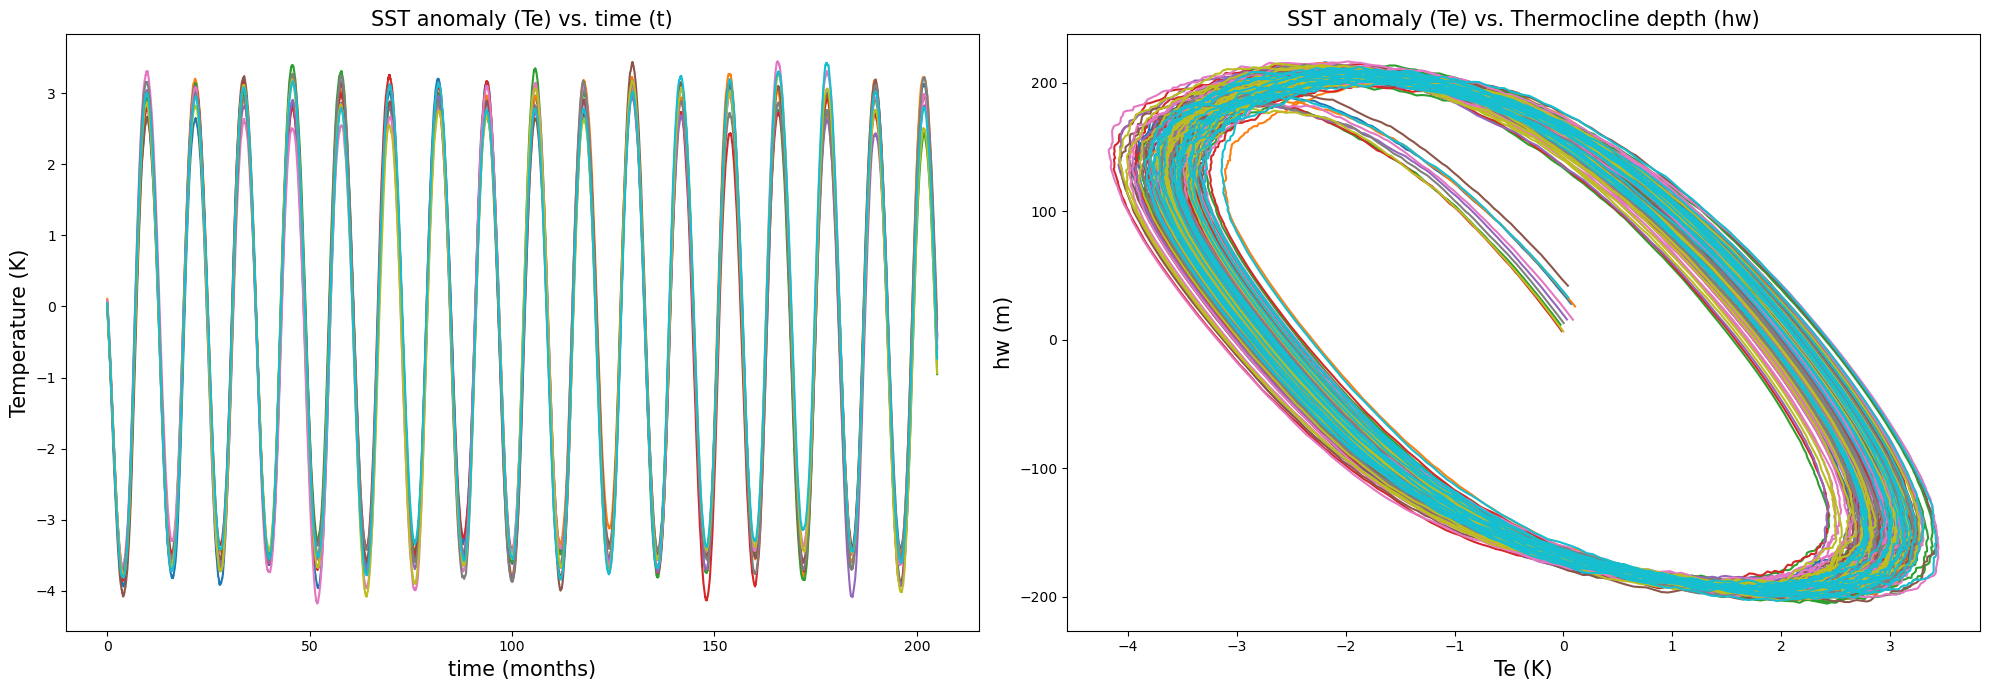

In [24]:
ROM_G(e = 0.1, t_max = (41/2)*5, f_ann = 1)
ROM_G(e = 0.1, t_max = (41/2)*5, f_ann = 1, f_ran = 0.8)
ROM_G(e = 0.1, t_max = (41/2)*5, f_ann = 2, f_ran = 0.8)

##### Figure 13: SST anomaly ($T_E$) plume time series graph (left), SST anomaly ($T_E$) vs. thermocline depth ($h_W$) phase plot (right), with an ensemble size of 10, and increasing annual and random wind stress forcing.

Figure 13 shows that increasing the stochastic forcing does not make Jin's model chaotic. Although the variables are becoming noisier and less correlated, they are still staying within the stable boundaries of the model, and there is not huge uncertainty between ensemble members. Therefore, Jin's model is not chaotic.

It is likely that Jin's model is far too simple, hence why it won't simulate chaos. If we had an equation to define the second parameter $\xi_2$ which represents the heating in the system, this may produce a chaotic system if it were added to the Runge-Kutta time scheme. Further research into alternative time schemes may also be necessary in finding a chaotic system, as Runge-Kutta is conditionally stable for large time steps.